  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
# import torch
# import torch.nn.functional as F
# from torchinfo import summary
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ..
insert ../../..
['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Pharmacophore_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [2]:
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.stats as stats
import plotly.express as px
# from   scipy.spatial.distance import pdist, squareform, euclidean
# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr

In [4]:
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.svm import SVC, SVR
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
# from sklearn.preprocessing import LabelEncoder

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
# from sklearn.model_selection._split import check_cv

# from sklearn.pipeline import Pipeline

# # regression matrics
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # classification metrics
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
# from sklearn.preprocessing import StandardScaler

In [5]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
# logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}   ")

2025-01-03 13:17:55,848 - __main__ - INFO: -  Excution started : 2025_01_03_13:17:55 
2025-01-03 13:17:55,850 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2025-01-03 13:17:55,851 - __main__ - INFO: -  Pandas version: 2.2.2   


In [6]:
from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ../output_10162023/compound_metadata_tpsa.csv
          + TPSA

## Test fingerprint generation (Adam)

Types of Groups in Pharmacophore fingerprint

        2: {   'Acceptor': 45,
               'Aromatic': 45,
               'Donor': 45,
               'Hydrophobe': 45,
               'LumpedHydrophobe': 45,
               'NegIonizable': 45,
               'PosIonizable': 45,
               'ZnBinder': 45},
     
        3: {   'Acceptor': 5085,
               'Aromatic': 5085,
               'Donor': 5085,
               'Hydrophobe': 5085,
               'LumpedHydrophobe': 5085,
               'NegIonizable': 5085,
               'PosIonizable': 5085,
               'ZnBinder': 5085}}

In [7]:
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
# FINGERPRINT_BINS = [(0,3),(3,8)]
FINGERPRINT_BINS = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# FINGERPRINT_BINS = [(0,3),(3,6),(6,9),(9,12),(12,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

2025-01-03 13:17:56,166 - rdkit - INFO: - Enabling RDKit 2023.03.3 jupyter extensions


 RDKit BaseFeatures.fdef : 13740


In [8]:
group_counter = dict()
group_counter[2] = dict()
group_counter[3] = dict()
for bit_id in range(FINGERPRINT_LENGTH):
    _tmp = sigFactory.GetBitDescription(bit_id)
    _tmp_len = len(_tmp)
    groups_list = _tmp.split('|')[0].split(' ')[:-1]
    # print(f" {bit_id:5d}      {_tmp:60s}     {groups_list}")
    grp_len = len(groups_list)
    for grp in groups_list:
        group_counter[grp_len][grp] = group_counter[grp_len].get(grp,0) + 1

pp.pprint(group_counter)

{   2: {   'Acceptor': 45,
           'Aromatic': 45,
           'Donor': 45,
           'Hydrophobe': 45,
           'LumpedHydrophobe': 45,
           'NegIonizable': 45,
           'PosIonizable': 45,
           'ZnBinder': 45},
    3: {   'Acceptor': 5085,
           'Aromatic': 5085,
           'Donor': 5085,
           'Hydrophobe': 5085,
           'LumpedHydrophobe': 5085,
           'NegIonizable': 5085,
           'PosIonizable': 5085,
           'ZnBinder': 5085}}


## Example of computing a fingerprint

In [ ]:
tmp = MolFromSmiles('c1ccc(CCCCCCCCCCCCCCCCCCc2ccccc2)cc1')
tmp

fp = Generate.Gen2DFingerprint(tmp, sigFactory)
fp.GetNumBits()
fp.GetNumOnBits()
fp.GetNumOffBits()
# int_vector = np.zeros((1032))
# int_vector[:10]

int_vector =fp.GetOnBits()
len(list(int_vector))
list(int_vector)

In [12]:
for bit_id in  ind_list:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

NameError: name 'ind_list' is not defined

In [319]:
for bit_id in  [134, 5941, 10462]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:   134    desc: LumpedHydrophobe LumpedHydrophobe |0 4|4 0| 
 bit:  5941    desc: Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 0 3|4 3 0| 
 bit: 10462    desc: Hydrophobe LumpedHydrophobe LumpedHydrophobe |0 4 4|4 0 4|4 4 0| 


In [337]:
for bit_id in  [2053, 2191, 5252]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:  2053    desc: Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0| 
 bit:  2191    desc: Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0| 
 bit:  5252    desc: Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0| 


In [7]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins([(0,3),(3,8)])
sigFactory.Init()
sigFactory.GetSigSize()
selected_bits_over60   = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                          390, 48, 231, 183, 383, 8]

selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
                          150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
                          83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
                          431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
                          417, 18, 244,  423, 84]
# for bit_id in range(11):
#     print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_50_to_55):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_over60):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

IndentationError: expected an indented block after 'for' statement on line 27 (2752080228.py, line 28)

In [126]:
# nPts, combo,scaffold = sigFactory.GetBitInfo(387)
nPts, combo,scaffold, labels, dMat = sigFactory._GetBitSummaryData(509)
nPts
combo
scaffold
labels
dMat

3

(1, 4, 4)

(1, 0, 1)

['Aromatic', 'LumpedHydrophobe', 'LumpedHydrophobe']

array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]])

## Selected Bit columns for 13740-A FP `[(0,1),(1,2),(2,3),(3,4),(4,100)]` - Between 5% and 70%

In [9]:
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
FINGERPRINT_BINS = [(0,1),(1,2),(2,3),(3,4),(4,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

 RDKit BaseFeatures.fdef : 13740


In [10]:
selected_label_indicies = np.array([
           1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,  1188,  1190,  1191,  1193,
        1194,  1195,  1196,  1234,  1235,  1236,  1237,  1238,  1251,  1260,  1261,  1262,  1263,  1274,  1276,  1282,  1284,  1285,  1287,  1297,
        1298,  1299,  1302,  1303,  1304,  1306,  1307,  1308,  1309,  1341,  1344,  1348,  1349,  1350,  1351,  1364,  1366,  1373,  1374,  1375,
        1376,  1387,  1389,  1395,  1397,  1398,  1399,  1400,  1410,  1411,  1412,  1414,  1415,  1416,  1417,  1419,  1420,  1421,  1422,  1461,
        1463,  1464,  1483,  1486,  1488,  1489,  1502,  1508,  1510,  1512,  1513,  1517,  1519,  1520,  1524,  1525,  1529,  1530,  1532,  1533,
        1534,  1535,  1690,  1715,  1739,  1756,  1759,  1761,  1976,  1977,  1982,  1984,  1985,  1986,  1987,  2042,  2048,  2052,  2053,  2054,
        2073,  2076,  2077,  2078,  2088,  2089,  2090,  2093,  2094,  2095,  2098,  2099,  2100,  2155,  2159,  2161,  2165,  2167,  2189,  2191,
        2196,  2197,  2198,  2200,  2203,  2206,  2208,  2210,  2211,  2212,  2213,  2393,  2438,  2439,  2607,  2609,  2630,  2632,  2633,  2653,
        2654,  2655,  2657,  2658,  2659,  2660,  2662,  2663,  2664,  2665,  2720,  2724,  2726,  2730,  2731,  2732,  2751,  2753,  2755,  2756,
        2760,  2761,  2762,  2763,  2767,  2768,  2772,  2773,  2775,  2776,  2777,  2778,  2956,  2958,  2982,  2999,  3002,  3003,  3004,  3197,
        3214,  3215,  3220,  3225,  3229,  3230,  3385,  3410,  3434,  3451,  3454,  3456,  4352,  4357,  4359,  4400,  4401,  4402,  4438,  4444,
        4451,  4461,  4466,  4470,  4471,  4472,  4473,  4512,  4513,  4514,  4515,  4540,  4561,  4564,  4579,  4583,  4584,  4585,  4586,  4628,
        4674,  4696,  4697,  4698,  4923,  5090,  5136,  5140,  5141,  5146,  5149,  5150,  5151,  5184,  5187,  5193,  5203,  5208,  5213,  5216,
        5217,  5218,  5225,  5227,  5235,  5240,  5241,  5242,  5248,  5249,  5252,  5254,  5257,  5259,  5262,  5263,  5264,  5306,  5316,  5323,
        5331,  5355,  5362,  5367,  5372,  5374,  5375,  5376,  5377,  5557,  5602,  5603,  5765,  5768,  5790,  5792,  5794,  5813,  5814,  5817,
        5819,  5821,  5822,  5823,  5824,  5826,  5827,  5828,  5829,  5871,  5881,  5896,  5920,  5927,  5932,  5937,  5939,  5940,  5941,  5942,
        6097,  6158,  6166,  6168,  6379,  6389,  6610,  7522,  7523,  7524,  7591,  7613,  7615,  7625,  7630,  7635,  7636,  7637,  7704,  7728,
        7747,  7748,  7749,  7750,  8146,  8167,  8170,  8190,  8191,  8192,  8194,  8195,  8196,  8197,  8199,  8200,  8201,  8202,  8253,  8259,
        8261,  8263,  8267,  8268,  8269,  8283,  8290,  8293,  8300,  8305,  8310,  8312,  8313,  8314,  8315,  8495,  8536,  8539,  8541,  8752,
        8757,  8762,  8767,  8993,  9833,  9862,  9885,  9889,  9890,  9894,  9895,  9896,  9897,  9927,  9938,  9939,  9963,  9964,  9988, 10007,
       10008, 10009, 10010, 10165, 10190, 10234, 10236, 10447, 10452, 10457, 10462, 10678, 10688])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies

533

In [11]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     1      Acceptor Acceptor |0 1|1 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     3      Acceptor Acceptor |0 3|3 0|                                     Acceptor Acceptor 
     6      Acceptor Aromatic |0 1|1 0|                                     Acceptor Aromatic 
     7      Acceptor Aromatic |0 2|2 0|                                     Acceptor Aromatic 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
    12      Acceptor Donor |0 2|2 0|                                        Acceptor Donor 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    18      Acceptor Hydrophobe |0 3|3 0|                                   Acceptor Hydrophobe 
    21      Acceptor LumpedHydrophobe |0 1|1 0|                             Acceptor LumpedHydrophobe 
    22      Acceptor LumpedHydrophobe |0 2|2 0

# Params

In [12]:
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
EMBEDDINGS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINTS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/"
MODEL_SAVE_PATH = f"./saved_fingerprint_models/embedded_models"

LATENT_DIM    = 150
fp_size = 13740
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)

EMBEDDED_METRICS_PATH = '../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = '../saved_fingerprint_models/profile_models'

11
161


In [13]:
## AUTOENCODER RUNMODE 
# AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
# AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
# AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols


# FINGERPRINTS_ALL_FILE        = f"3sample_pharmacophores_{fp_size}_HashOrder_all.csv"
# FINGERPRINTS_TRAINING_FILE   = f"3sample_pharmacophores_{fp_size}_HashOrder_training.csv"
# FINGERPRINTS_VALIDATION_FILE = f"3sample_pharmacophores_{fp_size}_HashOrder_validation.csv"
# FINGERPRINTS_TEST_FILE       = f"3sample_pharmacophores_{fp_size}_HashOrder_test.csv"

# print(FINGERPRINTS_ALL_FILE)
# print(FINGERPRINTS_TRAINING_FILE)
# print(FINGERPRINTS_VALIDATION_FILE)
# print(FINGERPRINTS_TEST_FILE)

# EMBEDDINGS_TRAINING_FILE   = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_training.csv'
# EMBEDDINGS_VALIDATION_FILE = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_validation.csv'
# EMBEDDINGS_TEST_FILE       = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_test.csv'

# print()
# print(EMBEDDINGS_TRAINING_FILE)
# print(EMBEDDINGS_VALIDATION_FILE)
# print(EMBEDDINGS_TEST_FILE)

# PROFILES_TRAINING_FILE   = f"3sample_profiles_{INPUT_COLS}_HashOrder_training_277200.csv"
# PROFILES_VALIDATION_FILE = f"3sample_profiles_{INPUT_COLS}_HashOrder_validation_21600.csv"
# PROFILES_TEST_FILE       = f"3sample_profiles_{INPUT_COLS}_HashOrder_test_12600.csv"
# print()
# print(PROFILES_TRAINING_FILE)
# print(PROFILES_VALIDATION_FILE)
# print(PROFILES_TEST_FILE)

# TRAIN_INPUT_X = os.path.join(EMBEDDINGS_INPUT_PATH, EMBEDDINGS_TRAINING_FILE)
# TRAIN_INPUT_Y = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TRAINING_FILE)
# TRAIN_INPUT_X
# TRAIN_INPUT_Y

# TEST_INPUT_X  = os.path.join(EMBEDDINGS_INPUT_PATH, EMBEDDINGS_TEST_FILE)
# TEST_INPUT_Y  = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TEST_FILE)
# TEST_INPUT_X
# TEST_INPUT_Y

In [14]:

# ESTIMATORS_FILENAME = f'PFP_LogReg_embeddings_bits_over60_20241106_0700_parmsearch.pkl'
# METRICS_FILENAME = f'PFP_LogReg_embeddings_bits_over60_20241106_0700_parmsearch_metrics.csv'
# MODEL_SAVE_PATH
# ESTIMATORS_FILENAME
# METRICS_FILENAME

# Helper methods

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def comparative_bar_chart(metrics1, metrics2, start = 0, end = 10, column  = 'mean_test_score'):

    # fingerprint_bits = metrics1.Y_bit.iloc[start:end].to_list()
    fingerprint_bits = metrics1.Y_bit.to_list()[start:end]
    # print(fingerprint_bits)
    # metric1[column]  # profile metrics
    # metric2[column]  # embedding metrics

    x = np.arange(len(fingerprint_bits))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig, ax = plt.subplots(figsize=(20,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2
    # print(f" x:                {x}")
    # print(f" fingerprint bits: {fingerprint_bits}")
    # print(x1)
    # print(x2)
    # print(x_ticks)
    # rects = ax.bar(x + offset, metrics2[column][start:end], width, label='Embeddings')
    rects = ax.bar(x1, metrics1[column][start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, metrics2[column][start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fingerprint_bits)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)


def metrics_bar_chart(df_mtrc, indicies, start = None, end = None, column  = 'mean_test_score'):

    fp_bit_ids = df_mtrc.loc[indicies,'Y_bit'].to_list()[start:end]

    x = np.arange(len(fp_bit_ids))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig, ax = plt.subplots(figsize=(20,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2

    rects = ax.bar(x1, df_mtrc.loc[indicies, column+'_p'].to_list()[start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, df_mtrc.loc[indicies, column+'_e'].to_list()[start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fp_bit_ids)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)

In [16]:
def display_metrics(df_mtr, indices):
    print(f" Number of rows: {len(indicies)}")
    print("                                         Profile       Embedding       ROC Diff   ")
    print("   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description ")
    print("   -----      ------     ----------     ---------      ---------       --------       ----------------------------------")
    for idx in indicies:
        print(f"   {idx:5d}    {df_mtr.at[idx,'Y_bit']:6d}     {df_mtr.at[idx,'Y_bit_pct']:10.5f}     {df_mtr.at[idx,'mean_test_score_p']:10.5f}"
              f"     {df_mtr.at[idx,'mean_test_score_e']:10.5f}   {df_mtr.at[idx,'ms_diff_pct']:11.2f}         {selected_label_descriptions[idx]}")

In [17]:
def plot_norm(data, ax, color = 'red', label = None):
    data_sorted = np.sort(data.to_numpy())
    mean = data_sorted.mean()
    std  = data_sorted.std()
    ax.plot(data_sorted, stats.norm.pdf(data_sorted, mean, std), color = color, label = label) 

In [18]:
def display_metrics(df_mtr, indices):
    print(f" Number of rows: {len(indicies)}")
    print("                                         Profile       Embedding       ROC Diff   ")
    print("   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description ")
    print("   -----      ------     ----------     ---------      ---------       --------       ----------------------------------")
    for idx in indicies:
        # description = selected_label_descriptions[idx].split('|')[0]
        # {selected_label_descriptions[idx]}
        print(f"   {idx:5d}    {df_mtr.at[idx,'Y_bit']:6d}     {df_mtr.at[idx,'Y_bit_pct']:10.5f}     {df_mtr.at[idx,'mean_test_score_p']:10.5f}"
              f"     {df_mtr.at[idx,'mean_test_score_e']:10.5f}   {df_mtr.at[idx,'ms_diff_pct']:11.2f}         {df_mtr.at[idx,'Y_bit_description']:50s}")

In [66]:
def plot_boxplots(df_data, indicies, width = 20, height =10, title = '', rotation = 10):
    # fig_width = max((len(indicies)*5/6) , 10)
    fig, ax = plt.subplots(1,1, figsize=(width,5))
    # _ = sns.boxplot(data=df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = 'group', hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = sns.boxplot(data = df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = "group", hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = ax.set_title(f'ROC distribution by FP group - {title}', size = 9)
    _ = ax.set_xlabel('')
    _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = rotation, ha="right")

# 13740 Fingerprint-A - Bins  `[(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]` - Selected bits between 05 % and 70%

Bits with a frequency between 5% and 70% of total compounds (number of bits > 70% is 4 bits and are included)

Total bits : 533
     
     Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement < 0%      :   184        34.52 %
      improvement > 0%      :   349        65.48 %
      Improvment Ratio      :  1.90
    
     Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement <= -5.0 %  :     8        1.50 % 
      improvement -5% to 0%  :   168       31.52 %
      improvement  0% to 5%  :   254       47.65 %
      improvement  5% to 10% :    90       16.89 %
      improvement >= 10%     :    13        2.44 %     

## Setup - read metrics files

In [19]:
FINGERPRINT_BINS

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]

In [23]:
FP_SUFFIX = 'A'
SEL_COLS = 'selcols0570'
EMBEDDED_METRICS_PATH = '../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = '../saved_fingerprint_models/profile_models'
EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_13740-{FP_SUFFIX}_quickscan_metrics_{SEL_COLS}_20241221_1200.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_13740-{FP_SUFFIX}_quickscan_metrics_{SEL_COLS}_20241223_0900.csv'
EMBEDDED_METRICS_FILENAME
PROFILES_METRICS_FILENAME

'PFP_LogReg_embeddings_13740-A_quickscan_metrics_selcols0570_20241221_1200.csv'

'PFP_LogReg_profiles_13740-A_quickscan_metrics_selcols0570_20241223_0900.csv'

In [24]:
embedded_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME))
profile_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME))
embedded_metrics.info()
profile_metrics.info()
embedded_metrics.head()
profile_metrics.head()
# embedded_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
# profile_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
# embedded_metrics.info()
# profile_metrics.info()
embedded_metrics.reset_index(inplace = True)
profile_metrics.reset_index(inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              533 non-null    int64  
 1   Y_bit_pct          533 non-null    float64
 2   param_C            533 non-null    float64
 3   param_solver       533 non-null    object 
 4   mean_test_score    533 non-null    float64
 5   precision          533 non-null    float64
 6   accuracy           533 non-null    float64
 7   recall             533 non-null    float64
 8   f1                 533 non-null    float64
 9   Y_bit_description  533 non-null    object 
 10  params             533 non-null    object 
 11  random_seed        533 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 50.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  --

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,1,0.096894,0.025,lbfgs,0.597127,1.000000,0.907460,0.000857,0.001712,Acceptor Acceptor |0 1|1 0|,none,6666
1,2,0.456115,0.025,lbfgs,0.553076,0.525526,0.558016,0.031328,0.059132,Acceptor Acceptor |0 2|2 0|,none,6666
2,3,0.308680,0.025,lbfgs,0.530178,0.333333,0.697778,0.001842,0.003663,Acceptor Acceptor |0 3|3 0|,none,6666
3,6,0.598463,0.025,lbfgs,0.558465,0.600289,0.599444,0.991653,0.747864,Acceptor Aromatic |0 1|1 0|,none,6666
4,7,0.661851,0.025,lbfgs,0.577239,0.665310,0.663651,0.994870,0.797380,Acceptor Aromatic |0 2|2 0|,none,6666


,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
1,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
2,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
3,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
4,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666


In [25]:
for col in ['Y_bit', 'Y_bit_description', 'Y_bit_pct']:
    print(f" {col:20s}  - {(embedded_metrics[col] == profile_metrics[col]).sum()}")

 Y_bit                 - 533
 Y_bit_description     - 533
 Y_bit_pct             - 533


## Join Profile and Embeded metrics 

In [26]:
df_metrics = profile_metrics.merge(embedded_metrics,
                                   left_on = ['Y_bit', 'Y_bit_description', 'Y_bit_pct'],
                                   right_on = ['Y_bit', 'Y_bit_description', 'Y_bit_pct'],
                                   suffixes=('_p', '_e'), how= 'inner', 
                                   indicator = True,  left_index=False, right_index=False, )
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,left_on =['Y_bit'], right_on = ['Y_bit'], suffixes=('_p', '_e'), how= 'inner', indicator = True,  left_index=False, right_index=False, )
# df_metrics.info()
df_metrics.drop(['index_e','param_C_p', 'param_C_e', 'param_solver_p', 'param_solver_e',
                 'params_p', 'params_e', 'random_seed_p', 'random_seed_e','_merge'], axis = 1, inplace = True)
df_metrics.info()
df_metrics.shape
df_metrics.head(20)
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,on ='Y_bit', rsuffix='_e', how= 'inner')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index_p            533 non-null    int64  
 1   Y_bit              533 non-null    int64  
 2   Y_bit_pct          533 non-null    float64
 3   mean_test_score_p  533 non-null    float64
 4   precision_p        533 non-null    float64
 5   accuracy_p         533 non-null    float64
 6   recall_p           533 non-null    float64
 7   f1_p               533 non-null    float64
 8   Y_bit_description  533 non-null    object 
 9   mean_test_score_e  533 non-null    float64
 10  precision_e        533 non-null    float64
 11  accuracy_e         533 non-null    float64
 12  recall_e           533 non-null    float64
 13  f1_e               533 non-null    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 58.4+ KB


(533, 14)

,index_p,Y_bit,Y_bit_pct,mean_test_score_p,precision_p,accuracy_p,recall_p,f1_p,Y_bit_description,mean_test_score_e,precision_e,accuracy_e,recall_e,f1_e
0,0,1,0.096894,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,0.597127,1.000000,0.907460,0.000857,0.001712
1,1,2,0.456115,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,0.553076,0.525526,0.558016,0.031328,0.059132
2,2,3,0.308680,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,0.530178,0.333333,0.697778,0.001842,0.003663
3,3,6,0.598463,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,0.558465,0.600289,0.599444,0.991653,0.747864
4,4,7,0.661851,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,0.577239,0.665310,0.663651,0.994870,0.797380
5,5,8,0.575801,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,0.571852,0.584478,0.580159,0.955255,0.725223
6,6,12,0.515574,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,0.542040,0.516372,0.521746,0.891342,0.653917
7,7,13,0.326115,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,0.564722,0.462963,0.682778,0.006261,0.012355
8,8,18,0.570574,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,0.545030,0.574651,0.574127,0.995856,0.728771
9,9,21,0.467186,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,0.574559,0.576528,0.547698,0.160114,0.250625


In [28]:
df_metrics['ms_diff'] = (df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)
df_metrics['ms_diff_grp'] = round(df_metrics.ms_diff * 100,0)
df_metrics['ms_diff_pct'] = round(((df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)  / df_metrics.mean_test_score_p) * 100.0,1)
df_metrics['ms_diff_pct_grp'] = round(df_metrics.ms_diff_pct,0)
df_metrics['roc_avg'] = (df_metrics.mean_test_score_e + df_metrics.mean_test_score_p) / 2

# df_metrics['ms_diff_norm'] = (df_metrics.ms_diff - np.average(df_metrics.ms_diff)) / (df_metrics.ms_diff.max() - df_metrics.ms_diff.min())
df_metrics['Y_bit_pct_grp'] = round(df_metrics.Y_bit_pct * 10,0)
df_metrics['fp_groups'] = df_metrics.Y_bit_description.apply(lambda x: x.split('|')[0].strip())
col_reorder = ['index_p', 'Y_bit', 'Y_bit_pct','Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e','ms_diff',  'roc_avg',  'ms_diff_pct', 
               'ms_diff_grp','ms_diff_pct_grp',
               'fp_groups', 'Y_bit_description',
               'precision_p', 'accuracy_p', 'recall_p', 'f1_p',
               'precision_e', 'accuracy_e', 'recall_e', 'f1_e',
            ]
df_metrics = df_metrics[col_reorder]

In [29]:
df_metrics.loc[334]
df_metrics.columns

index_p                                                         334
Y_bit                                                          4359
Y_bit_pct                                                  0.055465
Y_bit_pct_grp                                                   1.0
mean_test_score_p                                          0.668245
mean_test_score_e                                          0.615138
ms_diff                                                   -0.053106
roc_avg                                                    0.641692
ms_diff_pct                                                    -7.9
ms_diff_grp                                                    -5.0
ms_diff_pct_grp                                                -8.0
fp_groups                                Aromatic Aromatic Aromatic
Y_bit_description    Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|
precision_p                                                0.111111
accuracy_p                                      

Index(['index_p', 'Y_bit', 'Y_bit_pct', 'Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'roc_avg',
       'ms_diff_pct', 'ms_diff_grp', 'ms_diff_pct_grp', 'fp_groups', 'Y_bit_description', 'precision_p', 'accuracy_p', 'recall_p',
       'f1_p', 'precision_e', 'accuracy_e', 'recall_e', 'f1_e'],
      dtype='object')

In [30]:
sort_col = 'roc_avg'
df_metrics.sort_values(sort_col).head(10)
df_metrics.sort_values(sort_col).tail(10)
# df_metrics

,index_p,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,ms_diff,roc_avg,ms_diff_pct,ms_diff_grp,...,fp_groups,Y_bit_description,precision_p,accuracy_p,recall_p,f1_p,precision_e,accuracy_e,recall_e,f1_e
68,68,380,0.058701,1.0,0.509695,0.505200,-0.004495,0.507447,-0.9,-0.0,...,Acceptor Acceptor Aromatic,Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|,0.000000,0.942460,0.000000,0.000000,0.000000,0.942619,0.000000,0.00000
390,390,5252,0.137792,1.0,0.511957,0.510425,-0.001532,0.511191,-0.3,-0.0,...,Aromatic Donor Hydrophobe,Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,0.000000,0.866111,0.000000,0.000000,0.000000,0.866349,0.000000,0.00000
150,150,1261,0.075303,1.0,0.516980,0.513893,-0.003087,0.515437,-0.6,-0.0,...,Acceptor Aromatic Donor,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,0.000000,0.931270,0.000000,0.000000,0.000000,0.931667,0.000000,0.00000
155,155,1282,0.057262,1.0,0.524439,0.512954,-0.011485,0.518697,-2.2,-1.0,...,Acceptor Aromatic Donor,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,0.000000,0.947222,0.000000,0.000000,0.000000,0.947381,0.000000,0.00000
482,482,8267,0.074329,1.0,0.509844,0.531556,0.021712,0.520700,4.3,2.0,...,Donor Hydrophobe LumpedHydrophobe,Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...,0.000000,0.927778,0.000000,0.000000,0.000000,0.927857,0.000000,0.00000
74,74,393,0.082413,1.0,0.512922,0.528527,0.015605,0.520725,3.0,2.0,...,Acceptor Acceptor Aromatic,Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|,0.000000,0.922540,0.000000,0.000000,0.000000,0.923095,0.000000,0.00000
163,163,1303,0.061504,1.0,0.514080,0.528532,0.014452,0.521306,2.8,1.0,...,Acceptor Aromatic Donor,Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|,0.000000,0.940556,0.000000,0.000000,0.000000,0.940714,0.000000,0.00000
115,115,732,0.051807,1.0,0.517327,0.528219,0.010892,0.522773,2.1,1.0,...,Acceptor Acceptor LumpedHydrophobe,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,0.000000,0.952778,0.000000,0.000000,0.000000,0.953333,0.000000,0.00000
465,465,8167,0.234643,2.0,0.524674,0.521755,-0.002919,0.523214,-0.6,-0.0,...,Donor Hydrophobe Hydrophobe,Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|,0.333333,0.761349,0.000333,0.000665,0.333333,0.761032,0.001663,0.00331
235,235,2042,0.292056,3.0,0.533541,0.516381,-0.017160,0.524961,-3.2,-2.0,...,Acceptor Donor Hydrophobe,Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|,0.333333,0.715635,0.001118,0.002228,0.000000,0.715873,0.000000,0.00000


,index_p,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,ms_diff,roc_avg,ms_diff_pct,ms_diff_grp,...,fp_groups,Y_bit_description,precision_p,accuracy_p,recall_p,f1_p,precision_e,accuracy_e,recall_e,f1_e
521,521,10009,0.142229,1.0,0.625409,0.640266,0.014857,0.632838,2.4,1.0,...,Hydrophobe Hydrophobe LumpedHydrophobe,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,0.451613,0.854524,0.015326,0.029645,0.487179,0.854921,0.010400,0.020364
530,530,10462,0.111504,1.0,0.642696,0.630882,-0.011815,0.636789,-1.8,-1.0,...,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,0.433333,0.885556,0.018131,0.034806,0.441860,0.885794,0.013250,0.025728
27,27,59,0.644773,6.0,0.633596,0.643462,0.009866,0.638529,1.6,1.0,...,Aromatic LumpedHydrophobe,Aromatic LumpedHydrophobe |0 4|4 0|,0.651088,0.639524,0.937438,0.768454,0.643388,0.640556,0.979726,0.776710
334,334,4359,0.055465,1.0,0.668245,0.615138,-0.053106,0.641692,-7.9,-5.0,...,Aromatic Aromatic Aromatic,Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,0.111111,0.943175,0.002849,0.005556,0.153846,0.943571,0.002849,0.005594
529,529,10457,0.104026,1.0,0.639384,0.647333,0.007949,0.643359,1.2,1.0,...,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,0.457143,0.897857,0.012461,0.024261,0.433333,0.897778,0.010125,0.019787
55,55,134,0.399405,4.0,0.643446,0.646208,0.002762,0.644827,0.4,0.0,...,LumpedHydrophobe LumpedHydrophobe,LumpedHydrophobe LumpedHydrophobe |0 4|4 0|,0.603066,0.645556,0.286061,0.388052,0.622458,0.629127,0.142222,0.231541
363,363,4698,0.062630,1.0,0.663446,0.630254,-0.033192,0.646850,-5.0,-3.0,...,Aromatic Aromatic LumpedHydrophobe,Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...,0.250000,0.938492,0.006536,0.012739,0.117647,0.938254,0.002614,0.005115
435,435,5937,0.085119,1.0,0.649138,0.652390,0.003253,0.650764,0.5,0.0,...,Aromatic Hydrophobe LumpedHydrophobe,Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...,0.366667,0.915079,0.010358,0.020147,0.333333,0.915000,0.008475,0.016529
445,445,6389,0.055801,1.0,0.656373,0.654192,-0.002181,0.655282,-0.3,-0.0,...,Aromatic LumpedHydrophobe LumpedHydrophobe,Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...,0.333333,0.946746,0.007508,0.014684,0.368421,0.946746,0.010511,0.020438
353,353,4564,0.079957,1.0,0.661887,0.649429,-0.012458,0.655658,-1.9,-1.0,...,Aromatic Aromatic Hydrophobe,Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,0.333333,0.919841,0.007984,0.015595,0.285714,0.919762,0.005988,0.011730


In [31]:
for col in ['mean_test_score_p', 'mean_test_score_e' ]:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()
for col in ['Y_bit_pct',  'Y_bit_pct_grp', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'roc_avg']:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()

df_metrics.ms_diff_grp.value_counts().sort_index()
df_metrics.Y_bit_pct_grp.value_counts()
df_metrics.fp_groups.value_counts()[0:68]
FP_GROUPS = df_metrics.fp_groups.value_counts().index.to_list()
FP_GROUPS[:10]
len(FP_GROUPS)

mean_test_score_p   :    MIN:  0.50969    mean:  0.57039   std:  0.03227    MAX:  0.66824
mean_test_score_e   :    MIN:  0.50520    mean:  0.57984   std:  0.02945    MAX:  0.65419

Y_bit_pct           :    MIN:  0.05029    mean:  0.17971   std:  0.14406    MAX:  0.66895
Y_bit_pct_grp       :    MIN:  1.00000    mean:  1.90807   std:  1.37956    MAX:  7.00000
ms_diff             :    MIN: -0.05311    mean:  0.00945   std:  0.02111    MAX:  0.10085
ms_diff_grp         :    MIN: -5.00000    mean:  0.93246   std:  2.13966    MAX: 10.00000
ms_diff_pct         :    MIN: -7.90000    mean:  1.75422   std:  3.77343    MAX: 18.50000
ms_diff_pct_grp     :    MIN: -8.00000    mean:  1.71857   std:  3.77860    MAX: 18.00000
roc_avg             :    MIN:  0.50745    mean:  0.57512   std:  0.02903    MAX:  0.65566



ms_diff_grp
-5.0       1
-4.0       2
-3.0      16
-2.0      33
-1.0      86
 0.0      98
 1.0     115
 2.0      72
 3.0      49
 4.0      29
 5.0      20
 6.0       5
 7.0       3
 8.0       1
 9.0       1
 10.0      2
Name: count, dtype: int64

Y_bit_pct_grp
1.0    311
2.0     94
3.0     55
4.0     35
5.0     19
6.0     15
7.0      4
Name: count, dtype: int64

fp_groups
Acceptor Aromatic Hydrophobe              30
Acceptor Aromatic Donor                   26
Aromatic Donor Hydrophobe                 24
Acceptor Aromatic LumpedHydrophobe        23
Acceptor Hydrophobe LumpedHydrophobe      22
                                          ..
LumpedHydrophobe PosIonizable              2
Donor LumpedHydrophobe PosIonizable        1
Aromatic LumpedHydrophobe PosIonizable     1
Acceptor Hydrophobe                        1
Aromatic Aromatic PosIonizable             1
Name: count, Length: 67, dtype: int64

['Acceptor Aromatic Hydrophobe',
 'Acceptor Aromatic Donor',
 'Aromatic Donor Hydrophobe',
 'Acceptor Aromatic LumpedHydrophobe',
 'Acceptor Hydrophobe LumpedHydrophobe',
 'Acceptor Acceptor Aromatic',
 'Acceptor Donor Hydrophobe',
 'Acceptor Aromatic Aromatic',
 'Acceptor Donor LumpedHydrophobe',
 'Aromatic Hydrophobe Hydrophobe']

67

In [32]:
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','mean_score_diff','mean_score_diff_pct','Y_bit_description_e']].sort_values('mean_score_diff_pct', ascending = False)[-30:]
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','ms_diff','ms_diff_pct','ms_roc_avg','ms_diff_grp','bit_freq_grp','Y_bit_description_e']].sort_values('Y_bit_pct_p', ascending = False)[:10]

### Display mean_score Percentage differences 

In [57]:
def plot_norm(data, ax, color = 'red', label = None):
    data_sorted = np.sort(data.to_numpy())
    mean = data_sorted.mean()
    std  = data_sorted.std()
    ax.plot(data_sorted, stats.norm.pdf(data_sorted, mean, std), color = color, label = label) 

## Improvement Frequencies

In [63]:
len(df_metrics)
ttl_rows = len(df_metrics) / 100.0 
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement < 0%      : {(df_metrics.ms_diff_pct<= 0.00).sum():5d}       {(df_metrics.ms_diff_pct<= 0.00).sum()/ttl_rows:6.2f} %")
print(f"  improvement > 0%      : {(df_metrics.ms_diff_pct > 0.00).sum():5d}       {(df_metrics.ms_diff_pct > 0.00).sum()/ttl_rows:6.2f} %")
print(f"  Improvment Ratio      : {349/184:5.2f}")
print()
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement <= -5.0 %  : {(df_metrics.ms_diff_pct< -5.00).sum():5d}      {(df_metrics.ms_diff_pct< -5.00).sum()/ttl_rows:6.2f} % ")
print(f"  improvement -5% to 0%  : {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  0% to 5%  : {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  5% to 10% : {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement >= 10%     : {(df_metrics.ms_diff_pct >= 10.00).sum():5d}      {(df_metrics.ms_diff_pct >= 10.00).sum()/ttl_rows:6.2f} %")
print()
# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})

533

 Fingerprint Bits with ROC AUC improvement under Embedding Model: 

  improvement < 0%      :   184        34.52 %
  improvement > 0%      :   349        65.48 %
  Improvment Ratio      :  1.90

 Fingerprint Bits with ROC AUC improvement under Embedding Model: 

  improvement <= -5.0 %  :     8        1.50 % 
  improvement -5% to 0%  :   168       31.52 %
  improvement  0% to 5%  :   254       47.65 %
  improvement  5% to 10% :    90       16.89 %
  improvement >= 10%     :    13        2.44 %



## Histograms 

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(15,6))
bins_d = df_metrics.ms_diff_pct
bins_p = df_metrics.mean_test_score_p.to_numpy()
bins_e = df_metrics.mean_test_score_e.to_numpy()

bins = axes[0].hist(df_metrics.ms_diff_pct, color ='skyblue', bins=50, density = True )
y0,y1 = axes[0].get_ylim()
plot_norm(df_metrics.ms_diff_pct, axes[0], label = 'pdf')
_ = axes[0].set_title('ROC % AUC Change (Profile > Embedding )')
_ = axes[0].vlines(df_metrics.ms_diff_pct.mean(), y0,y1, linestyle = 'dashed', color = 'red')

_ = axes[1].hist(df_metrics.mean_test_score_p, color ='skyblue', label= 'profiles', bins=50, density = False)
_ = axes[1].hist(df_metrics.mean_test_score_e, color = 'orange', label='embedding', bins=50, alpha = 0.5, density = False)
y0,y1 = axes[1].get_ylim()
plot_norm(df_metrics.mean_test_score_p, axes[1], color = 'dodgerblue', label = 'Profiles PDF')
plot_norm(df_metrics.mean_test_score_e, axes[1], color = 'red', label = 'Embeddings PDF')
_ = axes[1].vlines(df_metrics.mean_test_score_p.mean(), y0,y1, linestyle = 'dashed', color = 'dodgerblue')
_ = axes[1].vlines(df_metrics.mean_test_score_e.mean(), y0,y1, linestyle = 'dashed', color = 'red')
_ = axes[1].set(title='ROC AUC Profile & Embedding Classification')
_ = axes[1].legend()

for col, name in [('ms_diff', 'ROC AUC Diff'), ('ms_diff_pct', 'ROC AUC Change %'), ('mean_test_score_p', 'ROC AUC Profiles'), ('mean_test_score_e', 'ROC_AUC Emebdding') ]:
    print(f"{name:20s}:    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}   min: {df_metrics[col].min():8.5f}   max: {df_metrics[col].max():8.5f}")
print('\n')

In [719]:
# grp = -5
# indicies =df_metrics[df_metrics.ms_diff_grp == grp].index
# print(indicies)
# df_metrics.loc[indicies]
# df_metrics.loc[indicies, ['Y_bit', 'mean_test_score_p', 'mean_test_score_e','Y_bit_pct', 'ms_diff']]

## ROC Plots 

-5 10


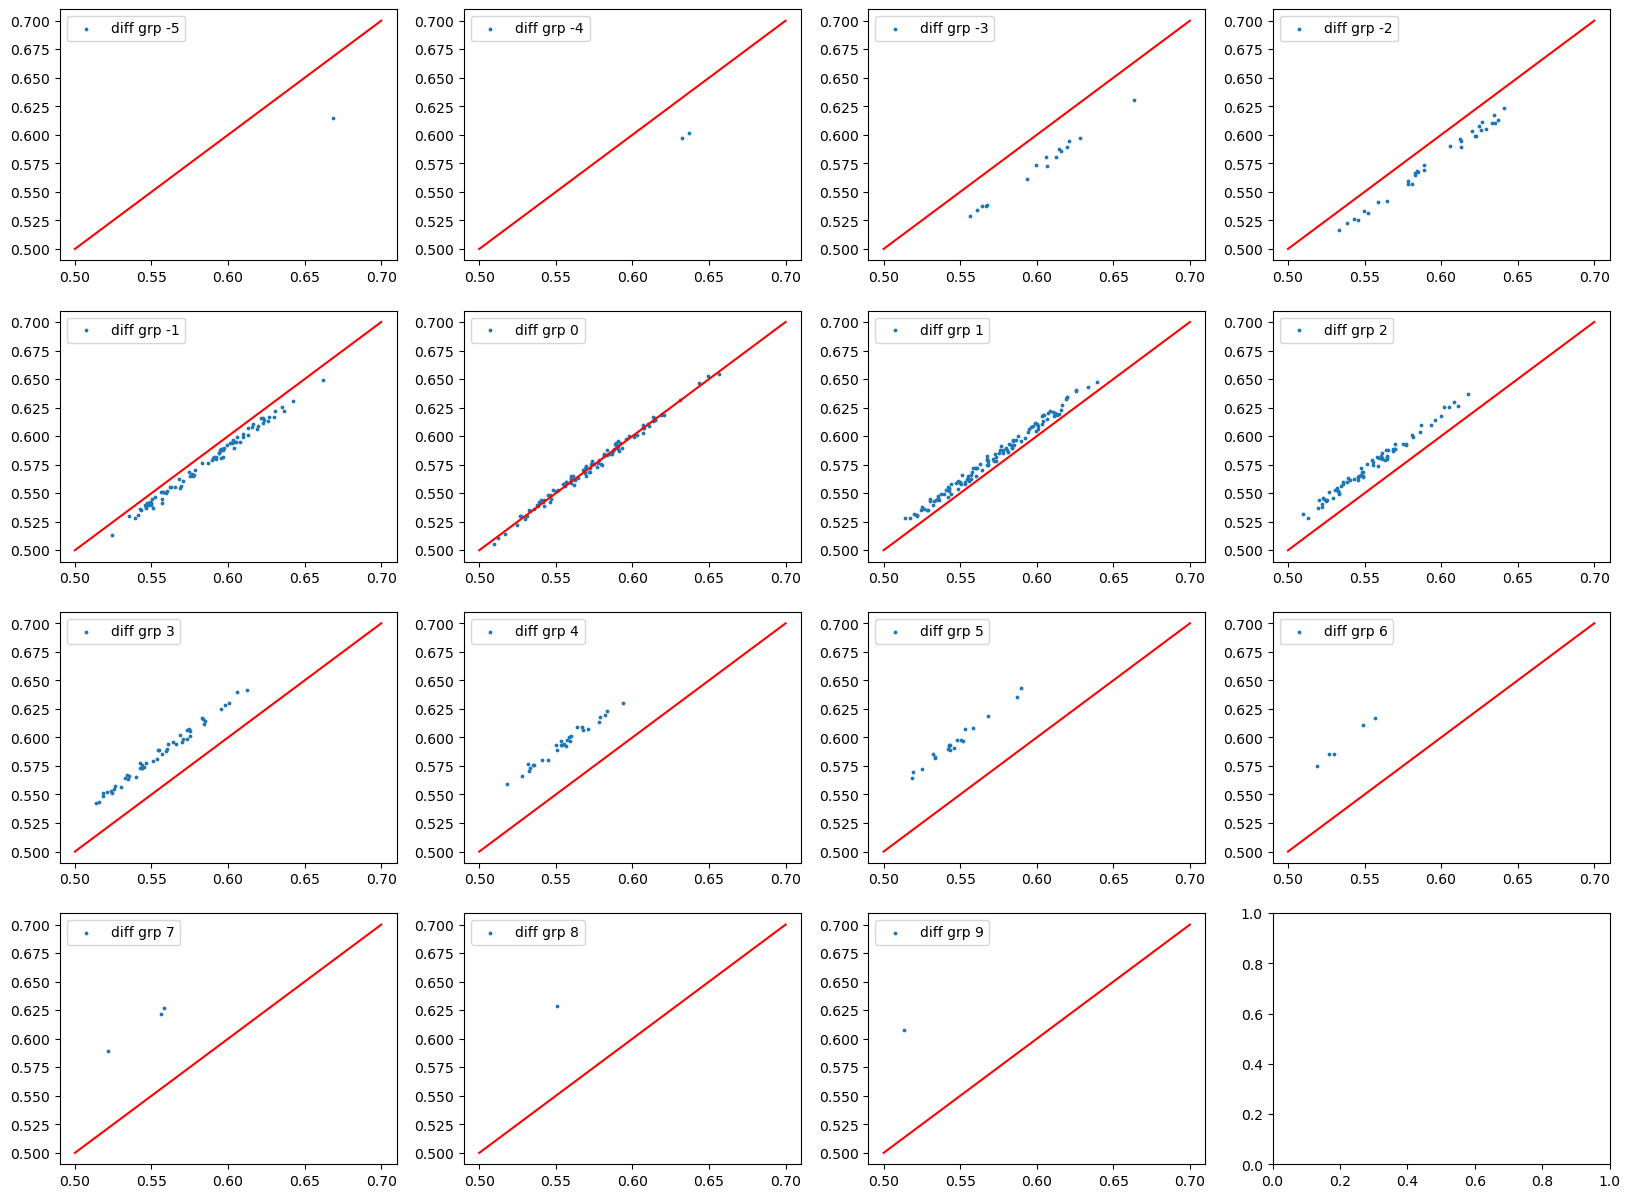

In [62]:
# _ = plt.figure(figsize = (15,15))
col = 'ms_diff_grp'
MIN = df_metrics[col].min().astype(np.int8)
MAX = df_metrics[col].max().astype(np.int8)
print(MIN, MAX)
fig, axes = plt.subplots(4,4, figsize=(20,15))
# type(fig), type(axes), axes.shape, type(axes.flat)
for ax, grp in zip(axes.flat, range(MIN,MAX)):
    indicies = (df_metrics.ms_diff_grp == grp)
 
    _ = ax.scatter(df_metrics[indicies].mean_test_score_p, df_metrics[indicies].mean_test_score_e, s= 3.0, label = f'diff grp {grp}')
    _ = ax.plot([0.5,0.7],[0.5,0.7], color = 'r')
    _ = ax.legend()

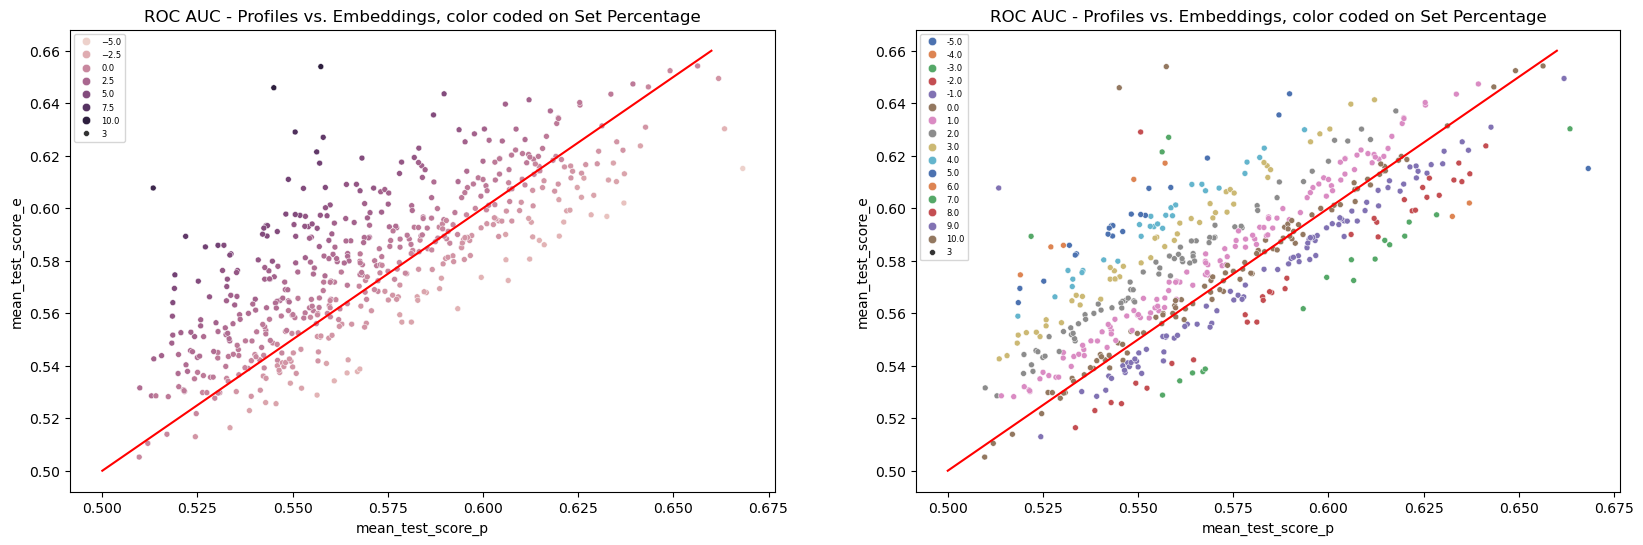

In [63]:
# plt.figure(figsize = (10,6))
fig, axes = plt.subplots(1,2, figsize=(20,6))
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', legend ='brief',size = 3, ax = axes[0])
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', palette = 'deep', legend ='brief',size = 3, ax = axes[1])
_ = axes[0].set_title('ROC AUC - Profiles vs. Embeddings, color coded on Set Percentage')
_ = axes[0].legend(fontsize='6', title_fontsize='12')
_ = axes[0].plot([0.5,0.66],[0.5,0.66], color = 'r')
_ = axes[1].set_title('ROC AUC - Profiles vs. Embeddings, color coded on Set Percentage')
_ = axes[1].legend(fontsize='6', title_fontsize='12')
_ = axes[1].plot([0.5,0.66],[0.5,0.66], color = 'r')
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

In [504]:
# _ = plt.figure(figsize = (12,12))
# _ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', palette = 'deep', legend ='brief', size = 3)
# _ = plt.legend(fontsize='6', title_fontsize='14')
# _ = plt.title('ROC AUC - Profiles vs. Embeddings, grouped by ROC_AUC Difference')
# _ = plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

## List Metrics - ROC_AVG (Best / Worst Fifty)

In [35]:
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
indicies_all = df_metrics.sort_values('roc_avg', ascending = False).index
df_metrics.loc[indicies_all][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e',		'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]

,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,roc_avg,fp_groups,Y_bit_description,ms_diff
353,4564,0.079957,1.0,0.661887,0.649429,0.655658,Aromatic Aromatic Hydrophobe,Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,-0.012458
445,6389,0.055801,1.0,0.656373,0.654192,0.655282,Aromatic LumpedHydrophobe LumpedHydrophobe,Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...,-0.002181
435,5937,0.085119,1.0,0.649138,0.652390,0.650764,Aromatic Hydrophobe LumpedHydrophobe,Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...,0.003253
363,4698,0.062630,1.0,0.663446,0.630254,0.646850,Aromatic Aromatic LumpedHydrophobe,Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...,-0.033192
55,134,0.399405,4.0,0.643446,0.646208,0.644827,LumpedHydrophobe LumpedHydrophobe,LumpedHydrophobe LumpedHydrophobe |0 4|4 0|,0.002762
...,...,...,...,...,...,...,...,...,...
482,8267,0.074329,1.0,0.509844,0.531556,0.520700,Donor Hydrophobe LumpedHydrophobe,Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...,0.021712
155,1282,0.057262,1.0,0.524439,0.512954,0.518697,Acceptor Aromatic Donor,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,-0.011485
150,1261,0.075303,1.0,0.516980,0.513893,0.515437,Acceptor Aromatic Donor,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,-0.003087
390,5252,0.137792,1.0,0.511957,0.510425,0.511191,Aromatic Donor Hydrophobe,Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,-0.001532


In [36]:
indicies_1 = indicies_all[:50]
indicies_2 = indicies_all[-50:]
indicies_1
indicies_2
# indicies = df_metrics[df_metrics.ms_diff_pct_grp <= -5.0].sort_values('ms_diff_pct').index
# display_metrics(df_metrics, indicies)
df_sav =df_metrics.loc[indicies_1][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e', 'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]
df_sav.info()
df_sav
df_sav.to_csv("best_fifty_bins_0_1_2.csv", index = False)


df_sav =df_metrics.loc[indicies_2][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e', 'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]
df_sav
df_sav.to_csv("worst_fifty_bins_0_1_2.csv", index = False)

Index([353, 445, 435, 363,  55, 529, 334,  27, 530, 521, 438,  17, 224, 432,  49, 440,  41, 527, 317, 328, 273, 439, 358, 227,  54,
       443, 313, 428, 532, 410,  29, 318, 357, 124, 523,  13, 526, 522, 495, 325, 517, 424, 411, 223, 314, 347, 409, 271, 441,
        52],
      dtype='int64')

Index([276, 113, 240,  95, 239,  73, 105, 265, 111, 467, 243,  70, 161,  72,  35, 145,  66, 392, 251, 181, 100,  61, 148, 112, 236,
       257,  87,  77, 103, 259, 146, 386,  99, 238, 143, 247, 101, 154, 102,   2, 235, 465, 115, 163,  74, 482, 155, 150, 390,
        68],
      dtype='int64')

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 353 to 52
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              50 non-null     int64  
 1   Y_bit_pct          50 non-null     float64
 2   Y_bit_pct_grp      50 non-null     float64
 3   mean_test_score_p  50 non-null     float64
 4   mean_test_score_e  50 non-null     float64
 5   roc_avg            50 non-null     float64
 6   fp_groups          50 non-null     object 
 7   Y_bit_description  50 non-null     object 
 8   ms_diff            50 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.9+ KB


,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,roc_avg,fp_groups,Y_bit_description,ms_diff
353,4564,0.079957,1.0,0.661887,0.649429,0.655658,Aromatic Aromatic Hydrophobe,Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,-0.012458
445,6389,0.055801,1.0,0.656373,0.654192,0.655282,Aromatic LumpedHydrophobe LumpedHydrophobe,Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...,-0.002181
435,5937,0.085119,1.0,0.649138,0.652390,0.650764,Aromatic Hydrophobe LumpedHydrophobe,Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...,0.003253
363,4698,0.062630,1.0,0.663446,0.630254,0.646850,Aromatic Aromatic LumpedHydrophobe,Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...,-0.033192
55,134,0.399405,4.0,0.643446,0.646208,0.644827,LumpedHydrophobe LumpedHydrophobe,LumpedHydrophobe LumpedHydrophobe |0 4|4 0|,0.002762
529,10457,0.104026,1.0,0.639384,0.647333,0.643359,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,0.007949
334,4359,0.055465,1.0,0.668245,0.615138,0.641692,Aromatic Aromatic Aromatic,Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,-0.053106
27,59,0.644773,6.0,0.633596,0.643462,0.638529,Aromatic LumpedHydrophobe,Aromatic LumpedHydrophobe |0 4|4 0|,0.009866
530,10462,0.111504,1.0,0.642696,0.630882,0.636789,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,-0.011815
521,10009,0.142229,1.0,0.625409,0.640266,0.632838,Hydrophobe Hydrophobe LumpedHydrophobe,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,0.014857


,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,roc_avg,fp_groups,Y_bit_description,ms_diff
276,2630,0.301623,3.0,0.524241,0.551099,0.537670,Acceptor Hydrophobe Hydrophobe,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,0.026858
113,726,0.056916,1.0,0.529268,0.545422,0.537345,Acceptor Acceptor LumpedHydrophobe,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,0.016155
240,2073,0.056905,1.0,0.530329,0.542937,0.536633,Acceptor Donor Hydrophobe,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,0.012608
95,583,0.052403,1.0,0.520646,0.552603,0.536624,Acceptor Acceptor Hydrophobe,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,0.031956
239,2054,0.414329,4.0,0.535864,0.536560,0.536212,Acceptor Donor Hydrophobe,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,0.000696
73,392,0.223474,2.0,0.541506,0.530673,0.536089,Acceptor Acceptor Aromatic,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,-0.010832
105,630,0.486721,5.0,0.532436,0.539733,0.536085,Acceptor Acceptor Hydrophobe,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,0.007298
265,2206,0.055584,1.0,0.545634,0.525544,0.535589,Acceptor Donor LumpedHydrophobe,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,-0.020090
111,721,0.062922,1.0,0.518507,0.551671,0.535089,Acceptor Acceptor LumpedHydrophobe,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,0.033164
467,8190,0.199351,2.0,0.525557,0.543651,0.534604,Donor Hydrophobe Hydrophobe,Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|,0.018094


In [37]:
df_sav = pd.read_csv("best_fifty_bins_0_1_2.csv")
df_sav
df_sav = pd.read_csv("worst_fifty_bins_0_1_2.csv")
df_sav

,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,roc_avg,fp_groups,Y_bit_description,ms_diff
0,4564,0.079957,1.0,0.661887,0.649429,0.655658,Aromatic Aromatic Hydrophobe,Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,-0.012458
1,6389,0.055801,1.0,0.656373,0.654192,0.655282,Aromatic LumpedHydrophobe LumpedHydrophobe,Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...,-0.002181
2,5937,0.085119,1.0,0.649138,0.652390,0.650764,Aromatic Hydrophobe LumpedHydrophobe,Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...,0.003253
3,4698,0.062630,1.0,0.663446,0.630254,0.646850,Aromatic Aromatic LumpedHydrophobe,Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...,-0.033192
4,134,0.399405,4.0,0.643446,0.646208,0.644827,LumpedHydrophobe LumpedHydrophobe,LumpedHydrophobe LumpedHydrophobe |0 4|4 0|,0.002762
5,10457,0.104026,1.0,0.639384,0.647333,0.643359,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,0.007949
6,4359,0.055465,1.0,0.668245,0.615138,0.641692,Aromatic Aromatic Aromatic,Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,-0.053106
7,59,0.644773,6.0,0.633596,0.643462,0.638529,Aromatic LumpedHydrophobe,Aromatic LumpedHydrophobe |0 4|4 0|,0.009866
8,10462,0.111504,1.0,0.642696,0.630882,0.636789,Hydrophobe LumpedHydrophobe LumpedHydrophobe,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,-0.011815
9,10009,0.142229,1.0,0.625409,0.640266,0.632838,Hydrophobe Hydrophobe LumpedHydrophobe,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,0.014857


,Y_bit,Y_bit_pct,Y_bit_pct_grp,mean_test_score_p,mean_test_score_e,roc_avg,fp_groups,Y_bit_description,ms_diff
0,2630,0.301623,3.0,0.524241,0.551099,0.537670,Acceptor Hydrophobe Hydrophobe,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,0.026858
1,726,0.056916,1.0,0.529268,0.545422,0.537345,Acceptor Acceptor LumpedHydrophobe,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,0.016155
2,2073,0.056905,1.0,0.530329,0.542937,0.536633,Acceptor Donor Hydrophobe,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,0.012608
3,583,0.052403,1.0,0.520646,0.552603,0.536624,Acceptor Acceptor Hydrophobe,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,0.031956
4,2054,0.414329,4.0,0.535864,0.536560,0.536212,Acceptor Donor Hydrophobe,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,0.000696
5,392,0.223474,2.0,0.541506,0.530673,0.536089,Acceptor Acceptor Aromatic,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,-0.010832
6,630,0.486721,5.0,0.532436,0.539733,0.536085,Acceptor Acceptor Hydrophobe,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,0.007298
7,2206,0.055584,1.0,0.545634,0.525544,0.535589,Acceptor Donor LumpedHydrophobe,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,-0.020090
8,721,0.062922,1.0,0.518507,0.551671,0.535089,Acceptor Acceptor LumpedHydrophobe,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,0.033164
9,8190,0.199351,2.0,0.525557,0.543651,0.534604,Donor Hydrophobe Hydrophobe,Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|,0.018094


## List Metrics - ROC Diff Pct

In [69]:
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
indicies = df_metrics[df_metrics.ms_diff_pct_grp <= -5.0].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 15
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     334      4359        0.05547        0.66824        0.61514         -7.90         Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|    
     326      3385        0.07407        0.60662        0.57247         -5.60         Acceptor LumpedHydrophobe PosIonizable |0 1 4|1 0 4|4 4 0|
     531     10678        0.07544        0.63254        0.59687         -5.60         Hydrophobe LumpedHydrophobe PosIonizable |0 4 2|4 0 4|2 4 0|
     357      4585        0.16650        0.63702        0.60198         -5.50         Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|  
     219      1533        0.08926        0.59337        0.56172         -5.30         Acceptor Aromatic LumpedH

In [70]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp >= 10].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 15
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
      86       495        0.05622        0.51895        0.56946          9.70         Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|       
     513      9927        0.08697        0.55284        0.60757          9.90         Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|1 0 1|2 1 0|
     373      5184        0.05924        0.53195        0.58588         10.10         Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|     
     342      4466        0.05400        0.53039        0.58586         10.50         Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|       
      96       584        0.06216        0.51907        0.57461         10.70         Acceptor Acceptor Hydrophobe |0 2 4

In [71]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(5.0, 10.0, 'right')].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 75
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     259      2191        0.18172        0.51557        0.54384          5.50         Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|
      48       113        0.28790        0.58390        0.61618          5.50         Hydrophobe LumpedHydrophobe |0 3|3 0|             
     249      2095        0.33549        0.52583        0.55518          5.60         Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|     
      54       133        0.10687        0.60588        0.63966          5.60         LumpedHydrophobe LumpedHydrophobe |0 3|3 0|       
     263      2200        0.05236        0.54265        0.57298          5.60         Acceptor Donor LumpedHydrophobe |0 4 2|4 0

In [72]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-5.0, 0, 'right')].index
display_metrics(df_metrics, indicies)

 Number of rows: 204
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       6        12        0.51557        0.54604        0.54204         -0.70         Acceptor Donor |0 2|2 0|                          
      10        22        0.50363        0.56437        0.56363         -0.10         Acceptor LumpedHydrophobe |0 2|2 0|               
      14        41        0.29024        0.59667        0.58197         -2.50         Aromatic Aromatic |0 1|1 0|                       
      16        43        0.26062        0.61882        0.60650         -2.00         Aromatic Aromatic |0 3|3 0|                       
      20        48        0.38479        0.54599        0.54000         -1.10         Aromatic Donor |0 3|3 0|                  

In [73]:
indicies = df_metrics.sort_values(['fp_groups', 'ms_diff_pct']).index
display_metrics(df_metrics, indicies)

 Number of rows: 533
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       1         2        0.45611        0.54812        0.55308          0.90         Acceptor Acceptor |0 2|2 0|                       
       2         3        0.30868        0.52159        0.53018          1.60         Acceptor Acceptor |0 3|3 0|                       
       0         1        0.09689        0.55903        0.59713          6.80         Acceptor Acceptor |0 1|1 0|                       
      62       292        0.54397        0.55641        0.52881         -5.00         Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|    
      61       291        0.27189        0.52842        0.53561          1.40         Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 

## FP Group Box Plots

In [38]:
df1 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_p, 'group': 'profiles'})
df2 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_e, 'group': 'embeddings'})

df1.index
df2.index
df_boxplot = pd.concat([df1,df2])
df_boxplot.sort_values(['FP_bit', 'group'],  inplace = True)
df_boxplot.reset_index(inplace=True)
df_boxplot.info()
# df_boxplot


RangeIndex(start=0, stop=533, step=1)

RangeIndex(start=0, stop=533, step=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1066 non-null   int64  
 1   FP_bit     1066 non-null   int64  
 2   FP_Family  1066 non-null   object 
 3   roc_auc    1066 non-null   float64
 4   group      1066 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 41.8+ KB


In [ ]:
sns.__version__
FP_GROUPS_SORTED = sorted(FP_GROUPS)
len(FP_GROUPS_SORTED)

In [40]:
for idx, grp in enumerate (FP_GROUPS_SORTED):
    print(f"  {idx:4d}  {grp:60s}")

     0  Acceptor Acceptor                                           
     1  Acceptor Acceptor Acceptor                                  
     2  Acceptor Acceptor Aromatic                                  
     3  Acceptor Acceptor Donor                                     
     4  Acceptor Acceptor Hydrophobe                                
     5  Acceptor Acceptor LumpedHydrophobe                          
     6  Acceptor Acceptor PosIonizable                              
     7  Acceptor Aromatic                                           
     8  Acceptor Aromatic Aromatic                                  
     9  Acceptor Aromatic Donor                                     
    10  Acceptor Aromatic Hydrophobe                                
    11  Acceptor Aromatic LumpedHydrophobe                          
    12  Acceptor Aromatic PosIonizable                              
    13  Acceptor Donor                                              
    14  Acceptor Donor Donor      

## Comparative Box Plots - 1 , Chart Per Group

In [84]:
indicies_1 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[:15])].index
indicies_2 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[15:30])].index
indicies_3 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[30:45])].index
indicies_4 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[45:60])].index
indicies_5 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[60:70])].index

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

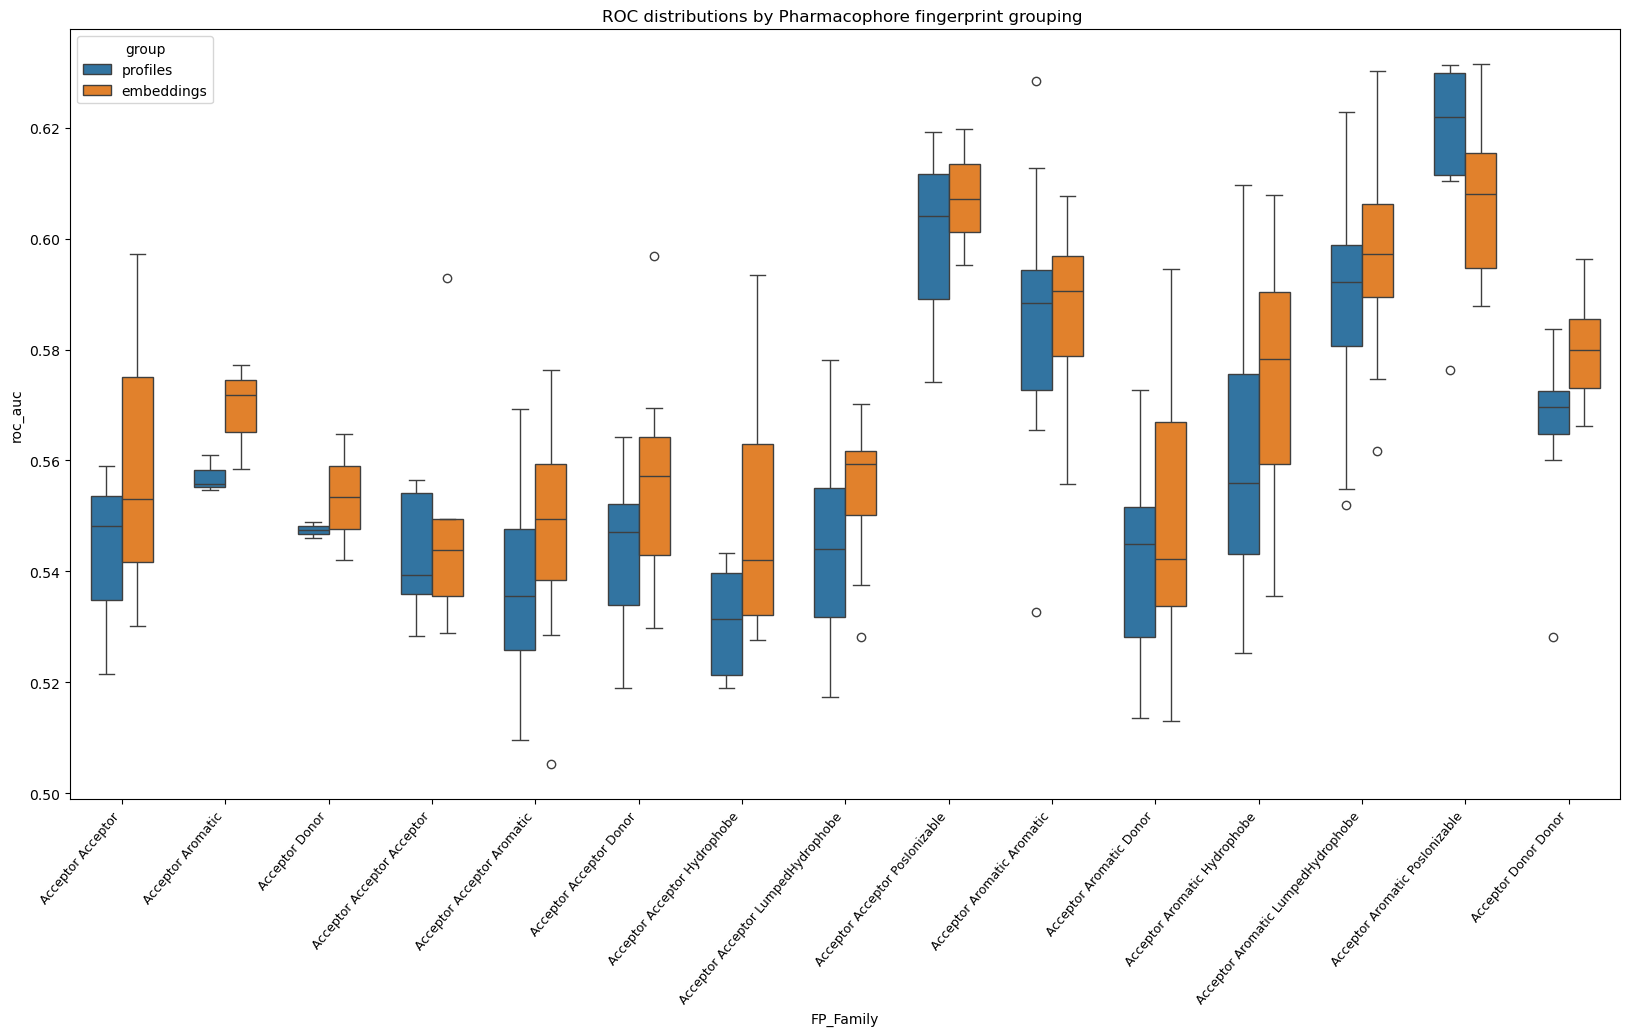

In [91]:
plot_boxplots(indicies_1)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

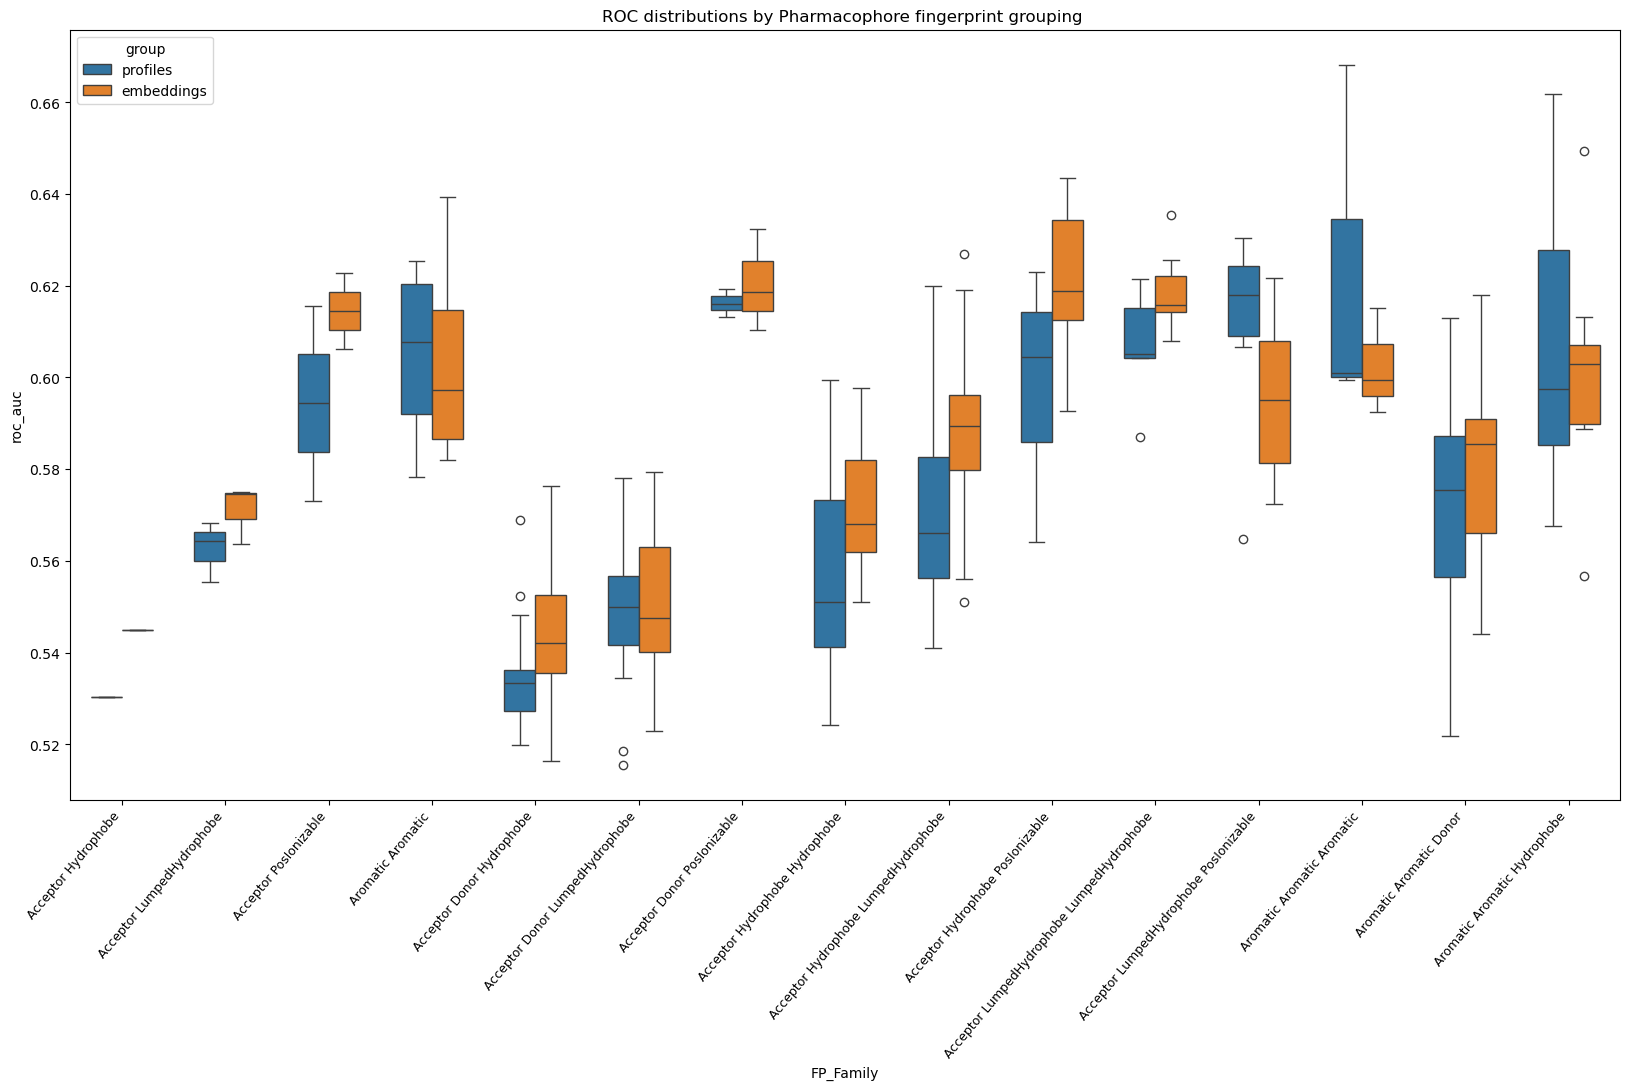

In [92]:
plot_boxplots(indicies_2)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

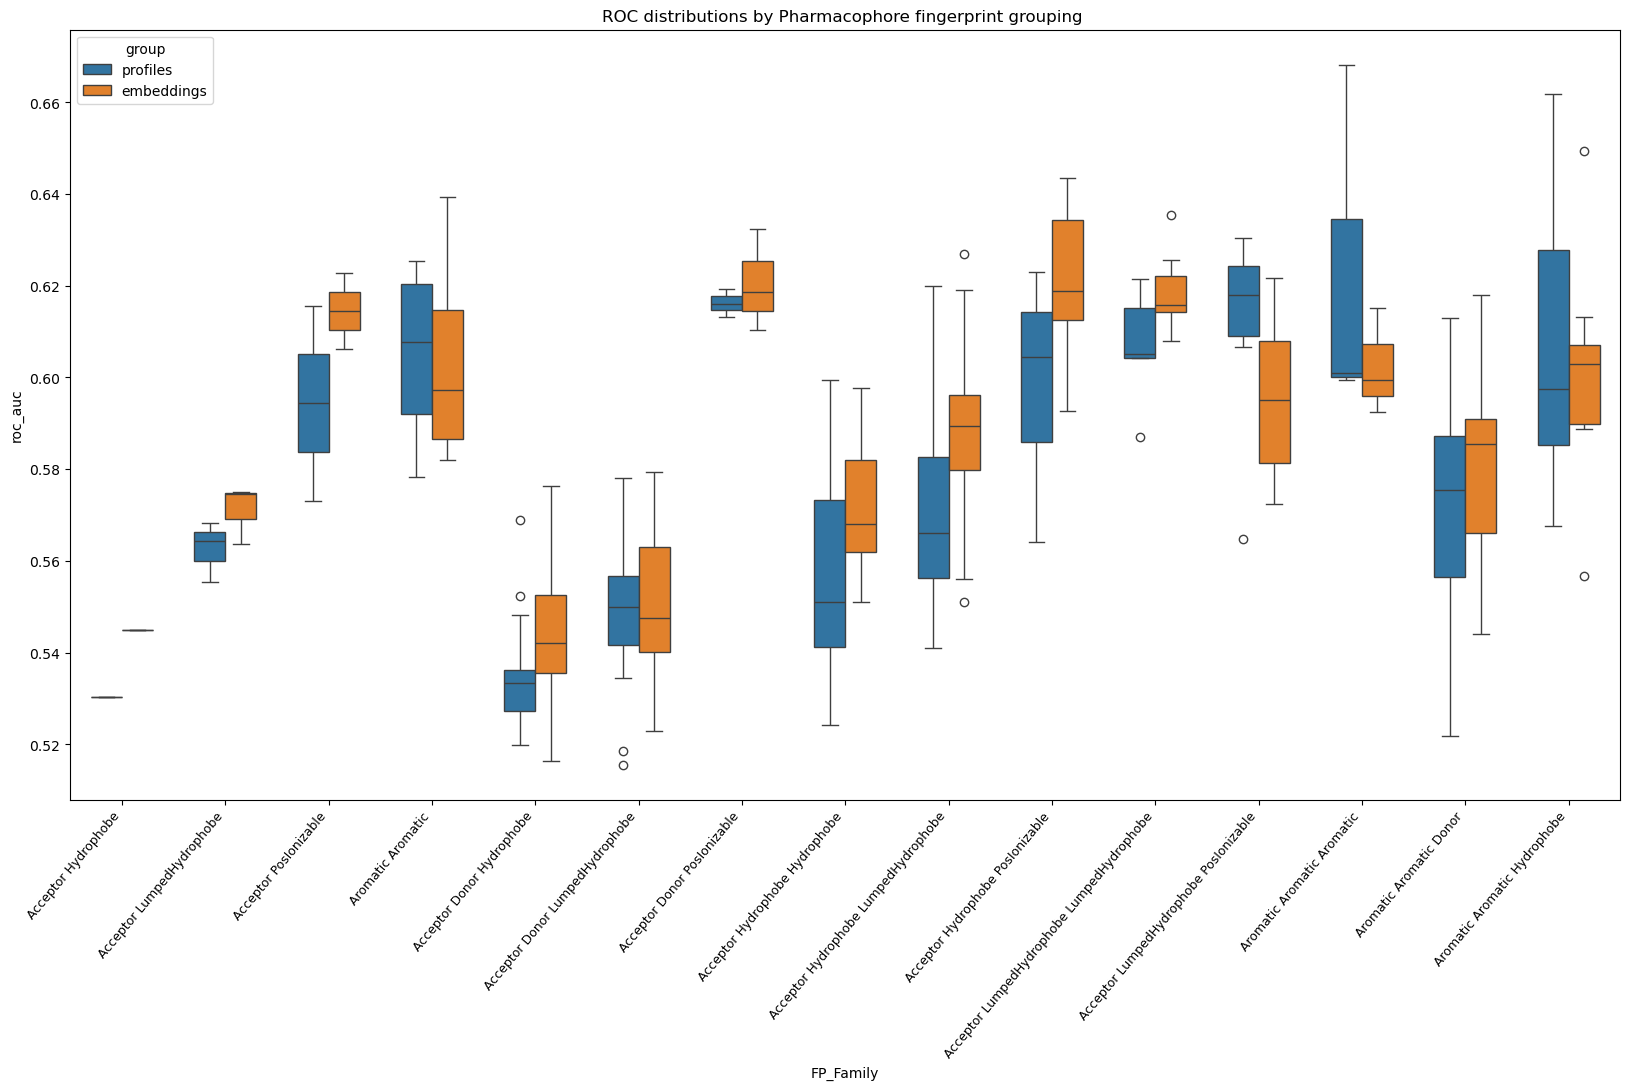

In [93]:
plot_boxplots(indicies_2)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

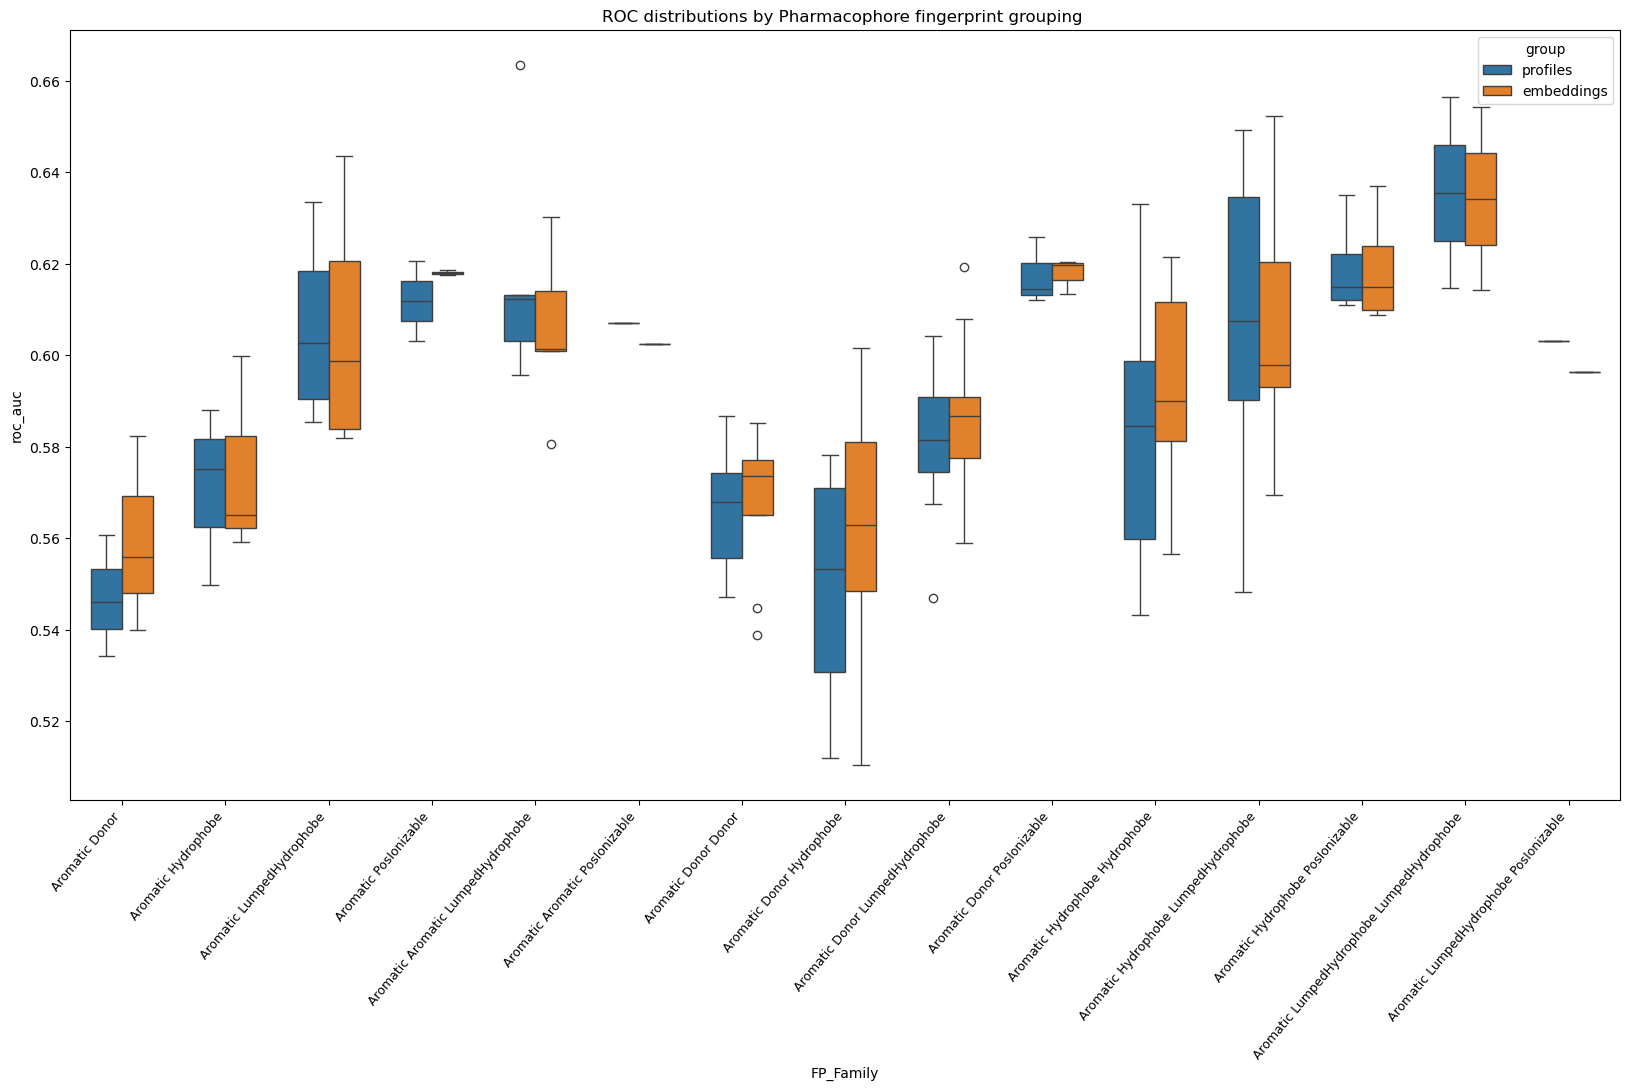

In [94]:
plot_boxplots(indicies_3)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

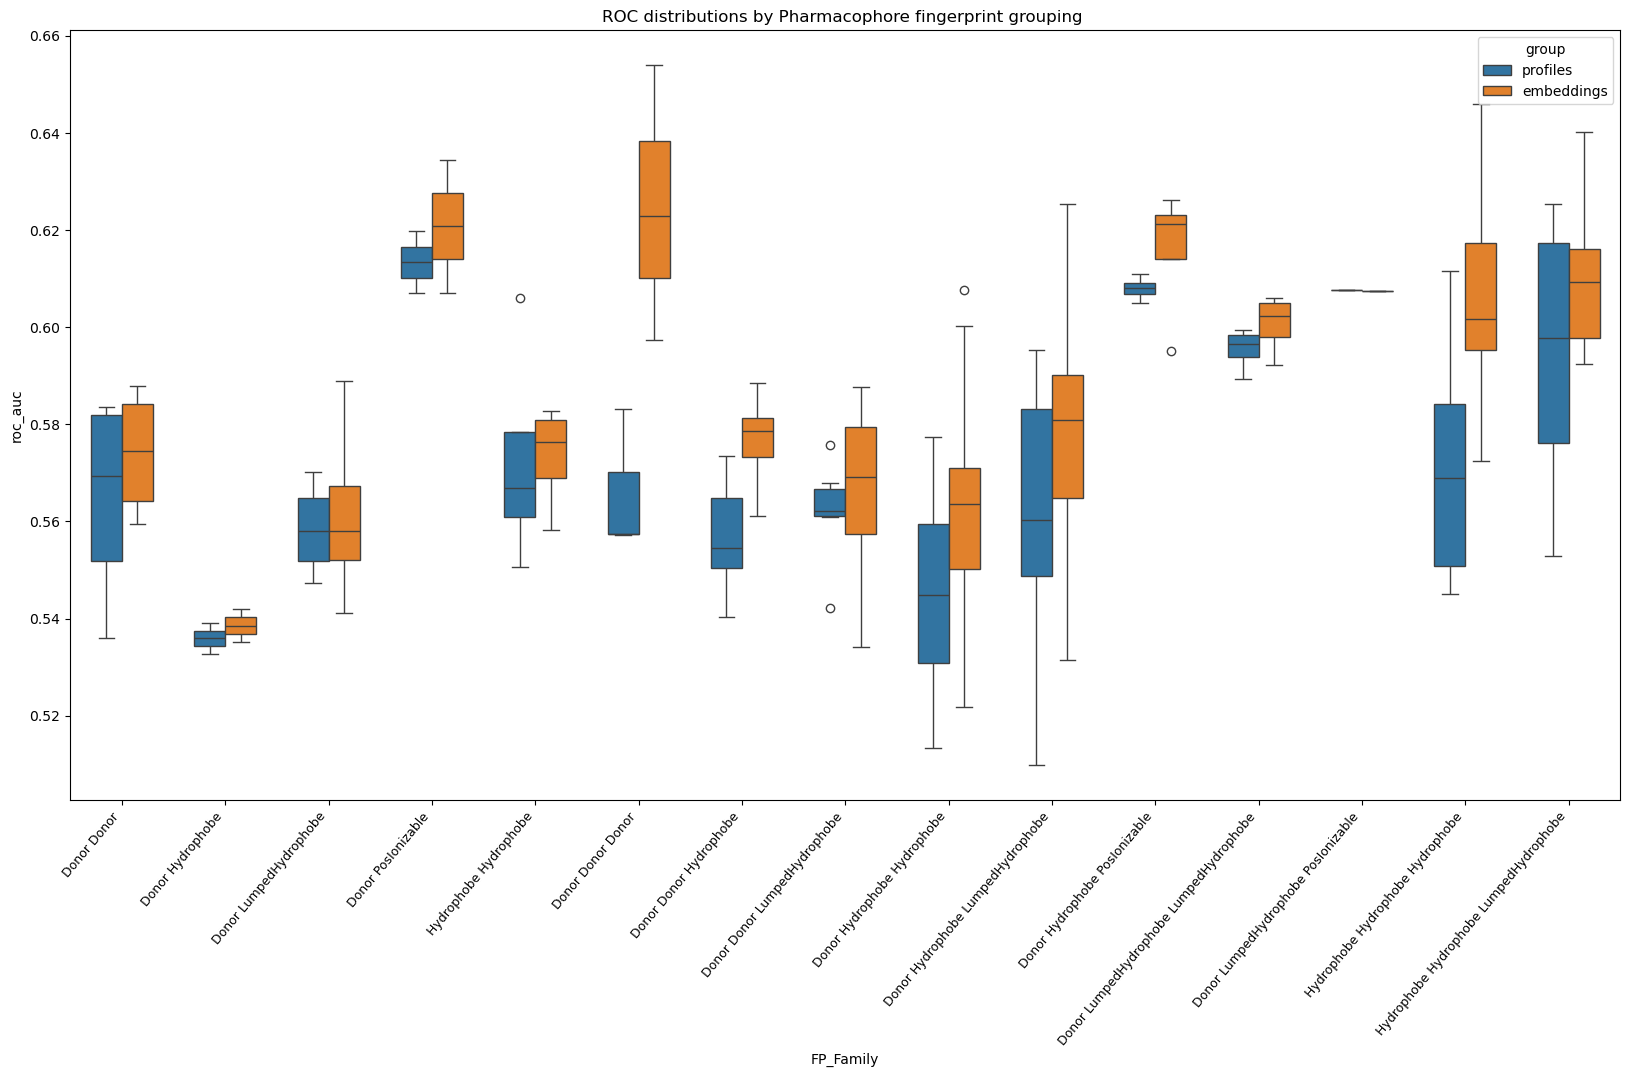

In [95]:
plot_boxplots(indicies_4)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

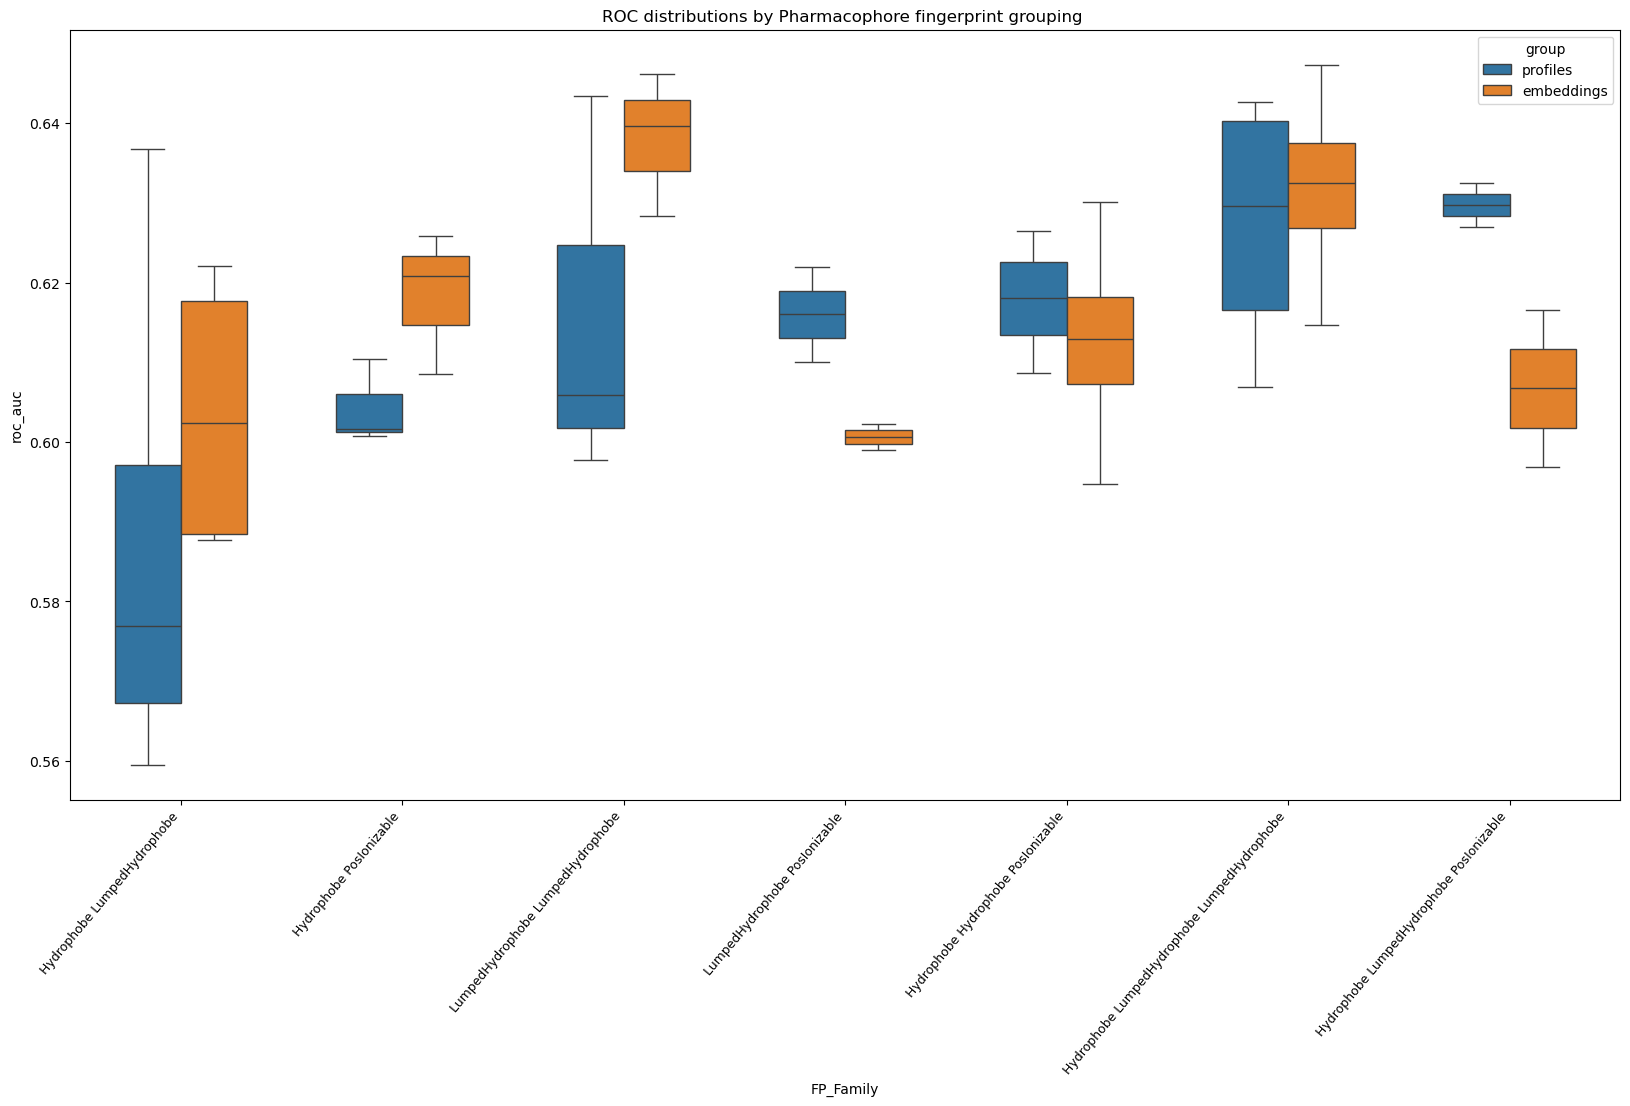

In [96]:
plot_boxplots(indicies_5)

In [982]:
# for ctr, (keys, group_data) in enumerate(grouped_data):
#     print(f"{ctr:5d}     {keys:60} {group_data.mean_test_score_p.mean():0.4f}  {group_data.mean_test_score_e.mean():0.4f}  {group_data.ms_diff_pct.mean():8.4f}")
#     plt.boxplot(group_data.mean_test_score_p)
#     plt.show()
#     if ctr > 2:
#         break
# print(group_data.info())

In [663]:
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

## Adam Selected Groups

In [73]:
ADAM_SELECTED_IDXS =  [ 29,27,64,12,40,56,6,17,36,21,25]
# ADAM_SELECTED_IDXS =  [ 6,12, 27,29, 36,40,56]
sorted(ADAM_SELECTED_IDXS)
ADAM_SELECTED_GRPS = [] 
for idx in sorted(ADAM_SELECTED_IDXS):
    ADAM_SELECTED_GRPS.append(FP_GROUPS_SORTED[idx])
ADAM_SELECTED_GRPS

[6, 12, 17, 21, 25, 27, 29, 36, 40, 56, 64]

['Acceptor Acceptor PosIonizable',
 'Acceptor Aromatic PosIonizable',
 'Acceptor Donor PosIonizable',
 'Acceptor Hydrophobe PosIonizable',
 'Acceptor PosIonizable',
 'Aromatic Aromatic Aromatic',
 'Aromatic Aromatic Hydrophobe',
 'Aromatic Donor PosIonizable',
 'Aromatic Hydrophobe PosIonizable',
 'Donor PosIonizable',
 'Hydrophobe PosIonizable']

In [74]:
adam_indicies = df_boxplot[df_boxplot.FP_Family.isin(ADAM_SELECTED_GRPS)].index
len(adam_indicies)

96

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

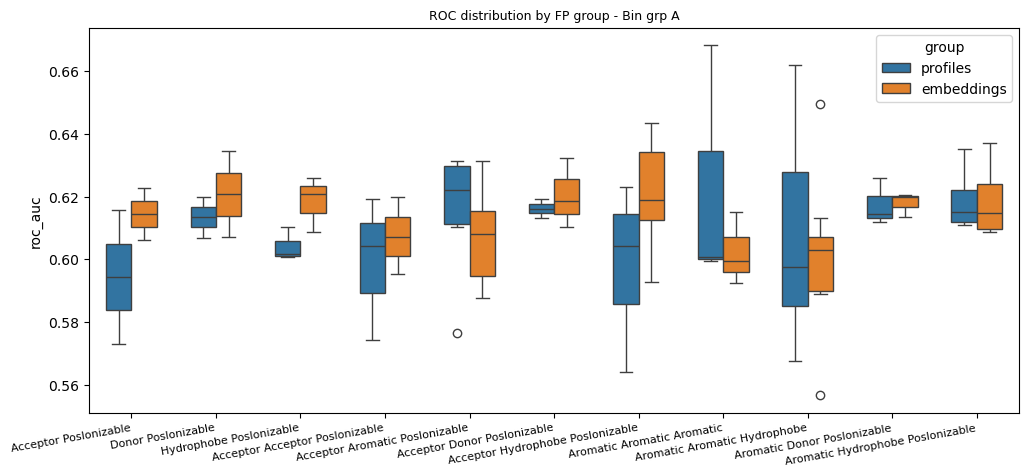

In [76]:
plot_boxplots(df_boxplot, adam_indicies, width =12, height = 6, title = 'Bin grp A')

## Group by fp_groups

In [ ]:
grouped_data = df_metrics.groupby('fp_groups') ## , group_keys = 'ms_diff_pct')
type(grouped_data)
len(grouped_data)
gd_mean = grouped_data[['mean_test_score_p', 'mean_test_score_e','ms_diff_pct']].mean()

In [98]:
grouped_data = df_metrics.groupby('fp_groups') ## , group_keys = 'ms_diff_pct')
type(grouped_data)
len(grouped_data)
gd_mean = grouped_data[['mean_test_score_p', 'mean_test_score_e','ms_diff_pct']].mean()

pandas.core.groupby.generic.DataFrameGroupBy

67

In [101]:
gd_mean.sort_values('ms_diff_pct').head(60)
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

,mean_test_score_p,mean_test_score_e,ms_diff_pct
fp_groups,,,
Hydrophobe LumpedHydrophobe PosIonizable,0.629763,0.606740,-3.650000
Aromatic Aromatic Aromatic,0.622881,0.602347,-3.133333
LumpedHydrophobe PosIonizable,0.616014,0.600625,-2.500000
Acceptor LumpedHydrophobe PosIonizable,0.610588,0.595590,-2.400000
Aromatic Aromatic LumpedHydrophobe,0.617545,0.605445,-1.880000
Acceptor Aromatic PosIonizable,0.615304,0.607229,-1.266667
Aromatic LumpedHydrophobe PosIonizable,0.603004,0.596366,-1.100000
Hydrophobe Hydrophobe PosIonizable,0.617839,0.612647,-0.825000
Aromatic Aromatic PosIonizable,0.607014,0.602545,-0.700000


## Comparative Bar charts - 1

In [685]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(10.0, 25, 'right')].index.to_list()
len(indicies)
indicies[None:None]

11

[96, 298, 306, 341, 385, 416, 449, 472, 483, 506, 508]

15

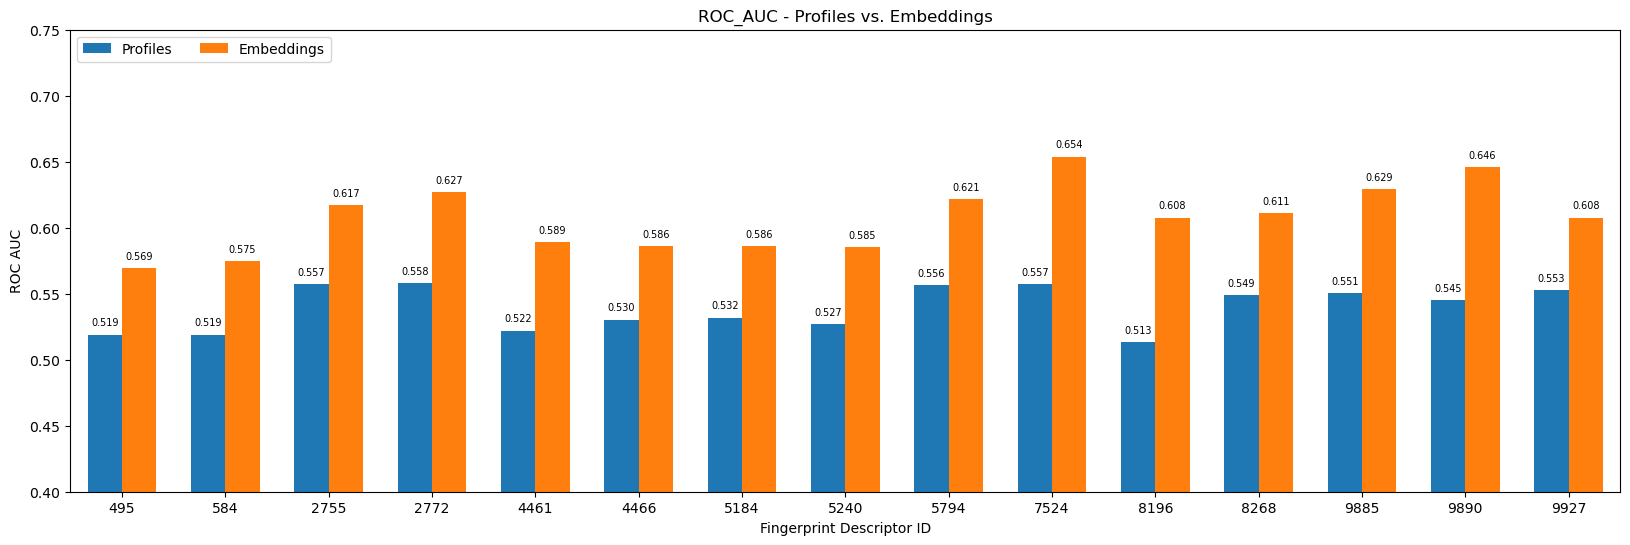

In [690]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(9.0, 25, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

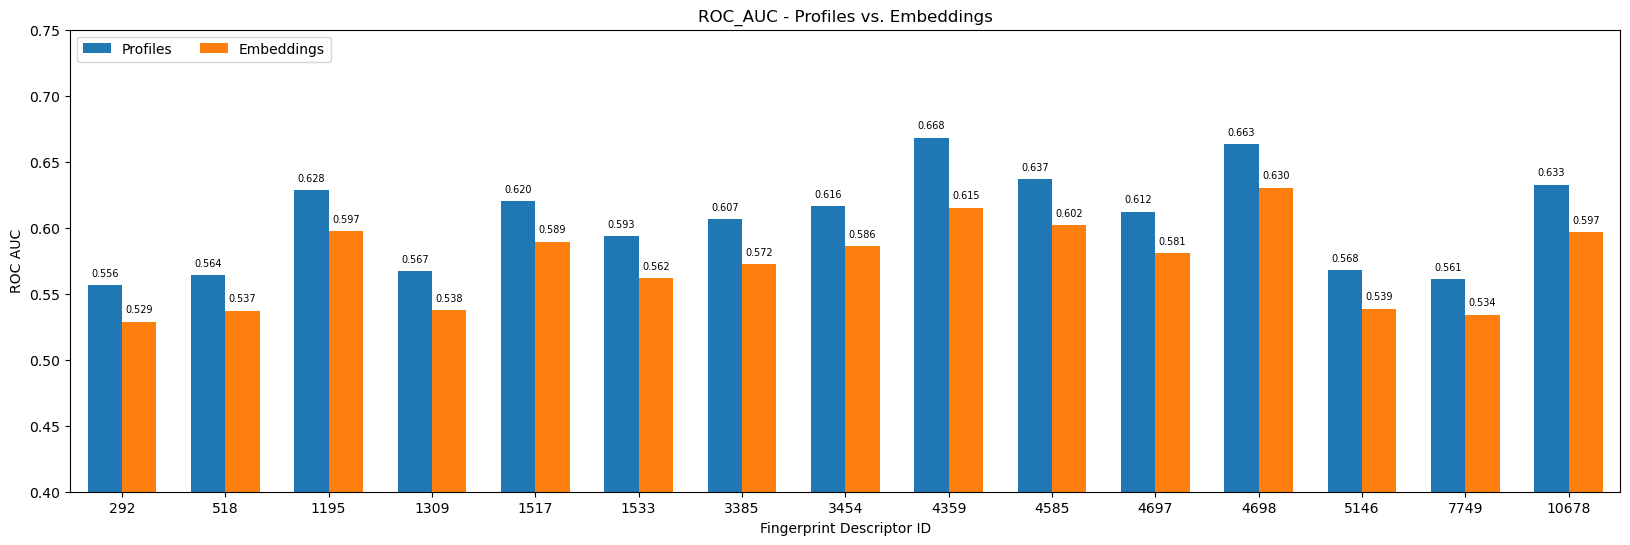

In [688]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-25, -5, 'right')].index
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

## Comparative Bar charts - 2

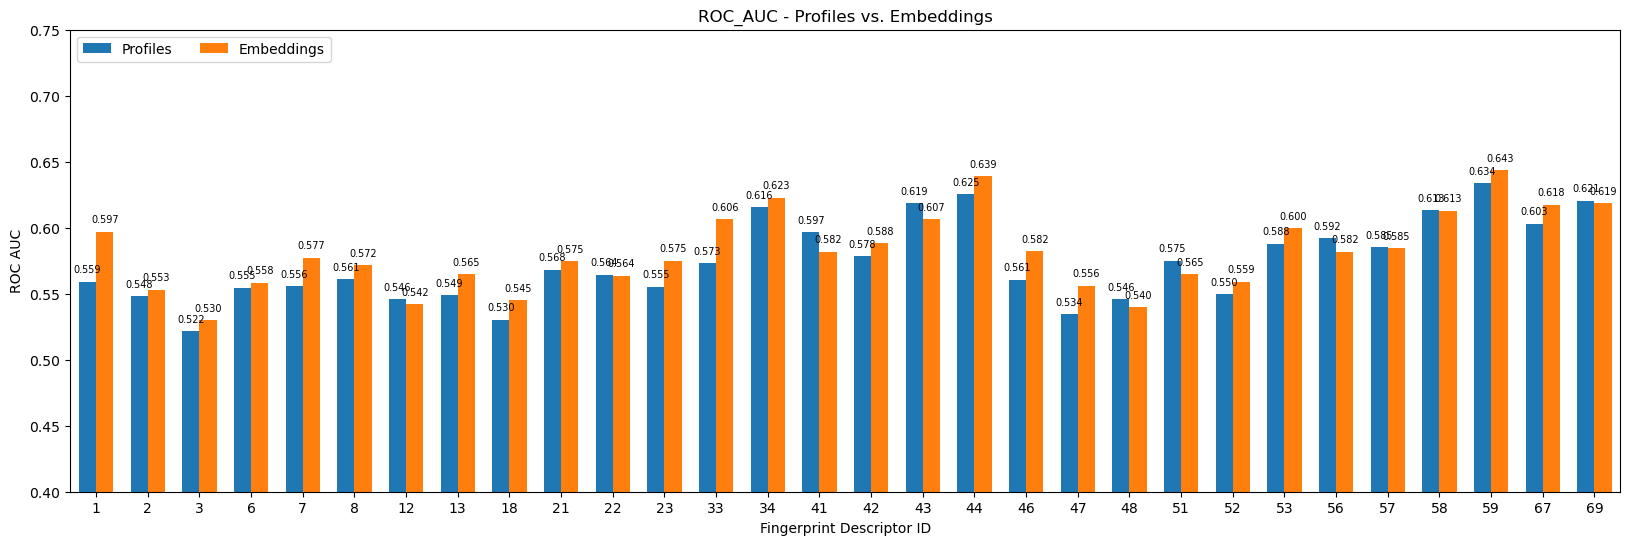

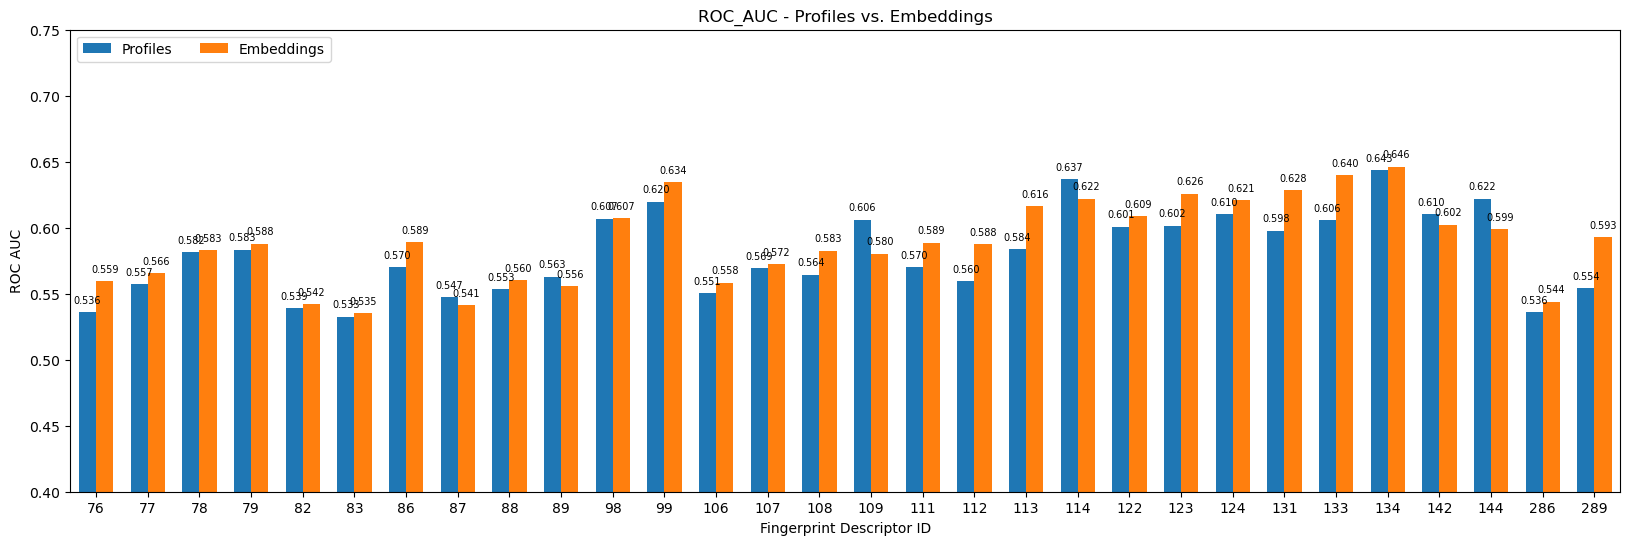

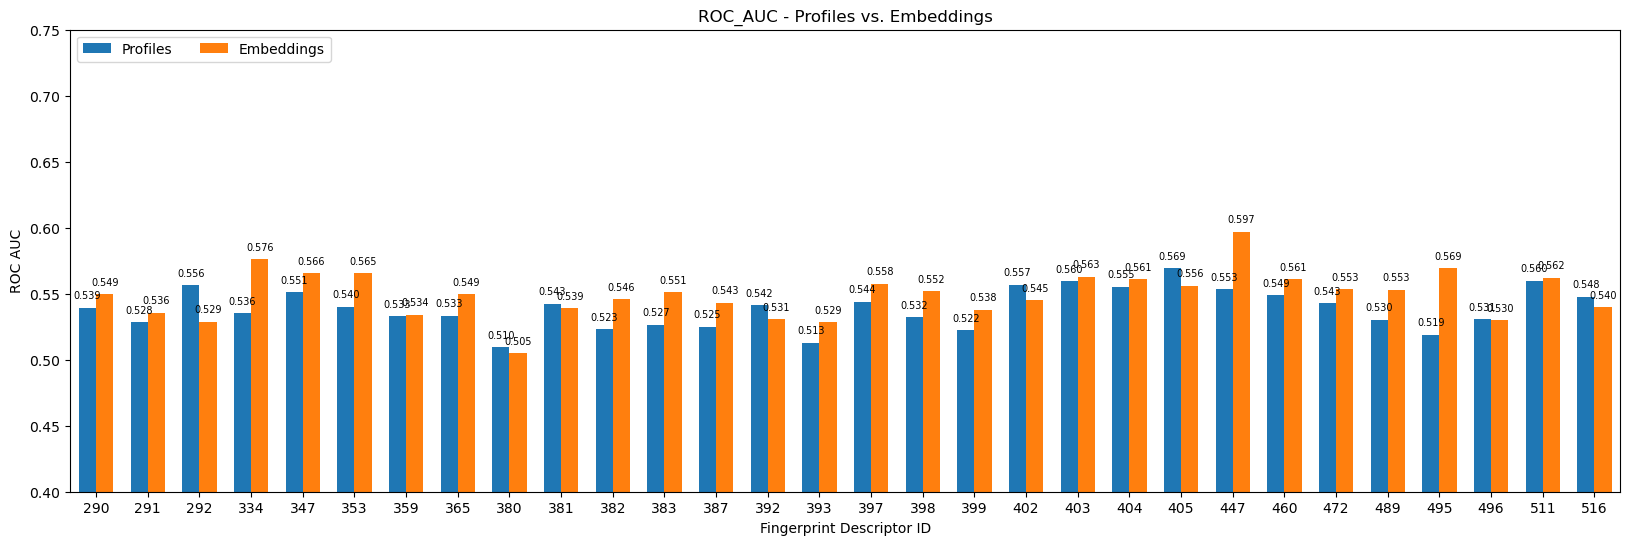

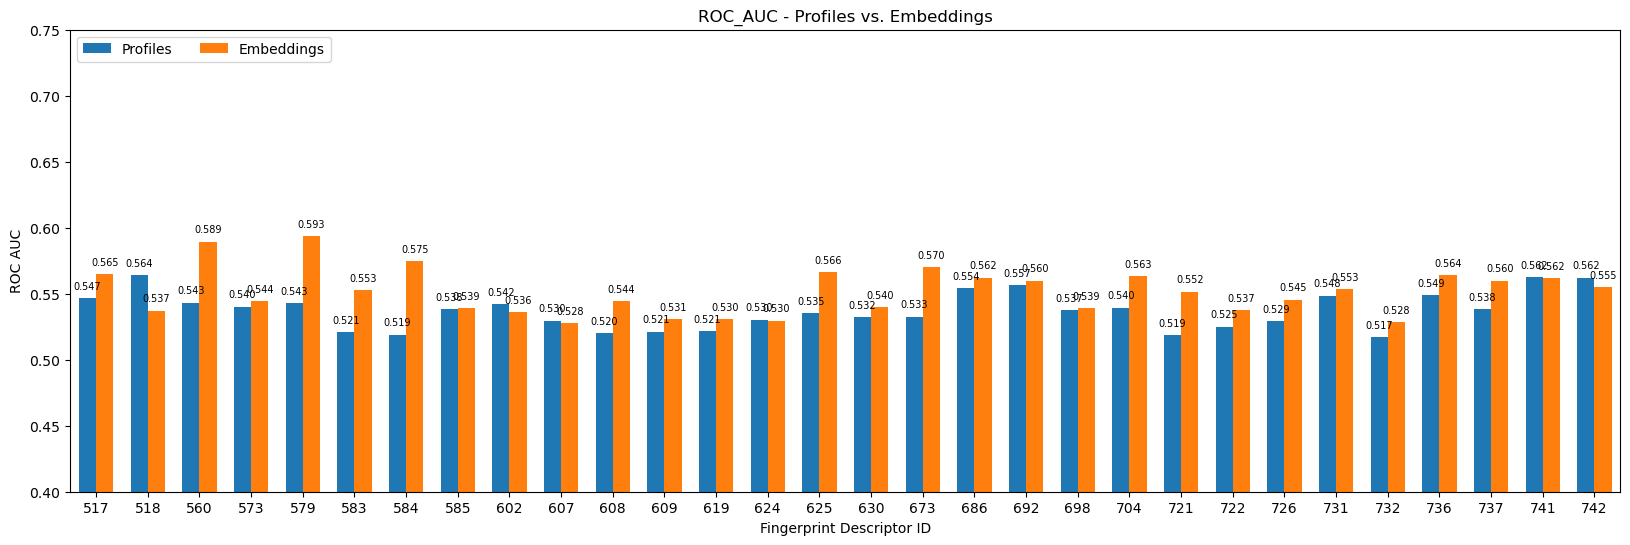

In [105]:
comparative_bar_chart(profile_metrics, embedded_metrics, start=  0, end =30, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 30, end =60, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 60, end =90, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 90, end =120, column = 'mean_test_score')
# comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 0, end  =10, column = 'mean_test_score')

In [200]:
# data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# Fingerprint_bits = profile_best_metrics.Y_bit
# scores = {
#     'Profiles': profile_best_metrics.mean_test_score,
#     'Embeddings': embedded_best_metrics.mean_test_score,
# }

# x = np.arange(len(Fingerprint_bits))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
# fig, ax = plt.subplots(figsize=(20,6))

# # for attribute, measurement in test_scores.items():
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
# multiplier += 1
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# # Add some text for labels, title and custom x-axis tick labels, etc.
# _ = ax.set_ylabel('ROC AUC')
# _ = ax.set_xlabel('Fingerprint Descriptor ID')
# _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
# _ = ax.set_xticks(x + width/2, Fingerprint_bits)
# _ = ax.legend(loc='upper left', ncols=3)
# _ = ax.set_ylim(0.4, 0.75)
# _ = ax.set_xlim(-1, 37)
 


# 13740 Fingerprint-A -  Bins  `[(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]` - Selected bits between 10% and 90%

Bits with a frequency between 10% and 90% of total compounds 
     
     Embedded score improvement < 0%      : 124  ( 39.4 %)
     Embedded score improvement 0% to 5%  : 165  ( 52.4 %) 
     Embedded score improvement 5% to 10% :  26  (  8.2 %) 
     Embedded score improvement > 10%     :   0  
    
     Total:                                  315

In [20]:
EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_13740-A_quickscan_metrics_selcols1090_20241215_1000.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_13740-A_quickscan_metrics_selcols1090_20241216_1000.csv'


In [26]:
embedded_best_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME),)
profile_best_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME),)
embedded_best_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
profile_best_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
embedded_best_metrics.info()
profile_best_metrics.info()
embedded_best_metrics.head()
profile_best_metrics.head()
# embedded_best_metrics.reset_index(inplace = True)
# profile_best_metrics.reset_index(inplace = True)
# embedded_best_metrics.info()
# profile_best_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              315 non-null    int64  
 1   Y_bit_pct          315 non-null    float64
 2   param_C            315 non-null    float64
 3   param_solver       315 non-null    object 
 4   mean_test_score    315 non-null    float64
 5   precision          315 non-null    float64
 6   accuracy           315 non-null    float64
 7   recall             315 non-null    float64
 8   f1                 315 non-null    float64
 9   Y_bit_description  315 non-null    object 
 10  params             315 non-null    object 
 11  random_seed        315 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 29.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  --

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,2,0.456115,0.025,lbfgs,0.553076,0.525526,0.558016,0.031328,0.059132,Acceptor Acceptor |0 2|2 0|,none,6666
1,3,0.308680,0.025,lbfgs,0.530178,0.333333,0.697778,0.001842,0.003663,Acceptor Acceptor |0 3|3 0|,none,6666
2,4,0.883669,0.025,lbfgs,0.561037,0.878771,0.878492,0.999639,0.935316,Acceptor Acceptor |0 4|4 0|,none,6666
3,6,0.598463,0.025,lbfgs,0.558465,0.600289,0.599444,0.991653,0.747864,Acceptor Aromatic |0 1|1 0|,none,6666
4,7,0.661851,0.025,lbfgs,0.577239,0.665310,0.663651,0.994870,0.797380,Acceptor Aromatic |0 2|2 0|,none,6666


,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
1,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
2,4,0.883669,0.025,lbfgs,0.563050,0.878745,0.877778,0.998736,0.934906,Acceptor Acceptor |0 4|4 0|,none,6666
3,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
4,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666


In [305]:
# s_diff = (( embedded_best_metrics.mean_test_score - profile_best_metrics.mean_test_score ) / profile_best_metrics.mean_test_score) * 100
# s_diff.min(), s_diff.max()
# s_diff[:100]

# print()
# print(f" num of bits where Embedded score improvement < 0%      : {(s_diff < 0.00).sum()} ")
# print(f" num of bits where Embedded score improvement 0% to 5%  : {s_diff.between(0.0, 5.0, inclusive = 'left').sum()}")
# print(f" num of bits where Embedded score improvement 5% to 10% : {s_diff.between(5.0, 10.00, inclusive = 'left').sum()}")
# print(f" num of bits where Embedded score improvement < 0%      : {(s_diff >= 10.00).sum()}  ")
# print()

In [289]:
# profile_best_metrics[50:100]
# embedded_best_metrics[50:100]

## Join Profile and Embeded metrics - merging into one dataframe

In [29]:
df_metrics= profile_best_metrics.merge(embedded_best_metrics,left_on ='Y_bit', right_on = 'Y_bit', suffixes=('_p', '_e'), how= 'inner', indicator = True,  left_index=False, right_index=False, )
(df_metrics['Y_bit_description_p'] == df_metrics['Y_bit_description_e']).sum()
df_metrics.info()
df_metrics.drop(['param_C_p', 'param_C_e', 'param_solver_p', 'param_solver_e',  'params_p', 'params_e', 'random_seed_p', 'random_seed_e'], axis = 1, inplace = True)
df_metrics.info()
df_metrics.shape
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,on ='Y_bit', rsuffix='_e', how= 'inner')

315

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Y_bit                315 non-null    int64   
 1   Y_bit_pct_p          315 non-null    float64 
 2   param_C_p            315 non-null    float64 
 3   param_solver_p       315 non-null    object  
 4   mean_test_score_p    315 non-null    float64 
 5   precision_p          315 non-null    float64 
 6   accuracy_p           315 non-null    float64 
 7   recall_p             315 non-null    float64 
 8   f1_p                 315 non-null    float64 
 9   Y_bit_description_p  315 non-null    object  
 10  params_p             315 non-null    object  
 11  random_seed_p        315 non-null    int64   
 12  Y_bit_pct_e          315 non-null    float64 
 13  param_C_e            315 non-null    float64 
 14  param_solver_e       315 non-null    object  
 15  mean_test_score_e    31

(315, 16)

In [415]:
# df_metrics.loc[50:100]

df_metrics['mean_score_diff'] = df_metrics.mean_test_score_e - df_metrics.mean_test_score_p
df_metrics['mean_score_diff_pct'] = (df_metrics.mean_score_diff  / df_metrics.mean_test_score_p)  * 100.0
df_metrics['mean_score_diff_norm'] = (df_metrics['mean_score_diff_pct'] - np.average(df_metrics.mean_score_diff_pct)) / (df_metrics.mean_score_diff_pct.max()- df_metrics.mean_score_diff_pct.min())
df_metrics['mean_score_diff_grp']  = round(df_metrics['mean_score_diff_norm'] * 10,0)
df_metrics['Y_bit_pct_grp']  = round(df_metrics['Y_bit_pct_p'] * 10,0)
np.average(df_metrics['mean_score_diff_pct']), df_metrics.mean_score_diff_pct.min(), df_metrics.mean_score_diff_pct.max()
np.average(df_metrics.mean_score_diff_norm), df_metrics.mean_score_diff_norm.min(), df_metrics.mean_score_diff_norm.max()
df_metrics
df_metrics.mean_score_diff_grp.value_counts()
df_metrics.Y_bit_pct_grp.value_counts()

(0.7310530961986619, -5.500364536087636, 9.275861588204503)

(7.93016446160826e-18, -0.42171915750814326, 0.5782808424918567)

,Y_bit,Y_bit_pct_p,mean_test_score_p,precision_p,accuracy_p,recall_p,f1_p,index_e,Y_bit_pct_e,mean_test_score_e,...,recall_e,f1_e,Y_bit_description_e,_merge,mean_score_diff,mean_score_diff_pct,mean_score_diff_pgrp,mean_score_diff_norm,mean_score_diff_grp,Y_bit_pct_grp
0,2,0.456115,0.548120,0.496894,0.555476,0.214823,0.299963,0,0.456115,0.553076,...,0.031328,0.059132,Acceptor Acceptor |0 2|2 0|,both,0.004957,0.904307,0.9,0.011725,0.0,5.0
1,3,0.308680,0.521589,0.532258,0.698651,0.008682,0.017085,1,0.308680,0.530178,...,0.001842,0.003663,Acceptor Acceptor |0 3|3 0|,both,0.008588,1.646537,1.6,0.061957,1.0,3.0
2,4,0.883669,0.563050,0.878745,0.877778,0.998736,0.934906,2,0.883669,0.561037,...,0.999639,0.935316,Acceptor Acceptor |0 4|4 0|,both,-0.002012,-0.357404,-0.4,-0.073663,-1.0,9.0
3,6,0.598463,0.554677,0.600821,0.595952,0.969926,0.742006,3,0.598463,0.558465,...,0.991653,0.747864,Acceptor Aromatic |0 1|1 0|,both,0.003788,0.682864,0.7,-0.003261,-0.0,6.0
4,7,0.661851,0.555710,0.665949,0.665317,0.997017,0.798528,4,0.661851,0.577239,...,0.994870,0.797380,Acceptor Aromatic |0 2|2 0|,both,0.021529,3.874228,3.9,0.212718,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,10009,0.142229,0.625409,0.451613,0.854524,0.015326,0.029645,310,0.142229,0.640266,...,0.010400,0.020364,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,both,0.014857,2.375586,2.4,0.111296,1.0,1.0
311,10010,0.191926,0.623536,0.433333,0.805476,0.032138,0.059839,311,0.191926,0.614085,...,0.016069,0.031026,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,both,-0.009452,-1.515833,-1.5,-0.152061,-2.0,2.0
312,10447,0.115574,0.619835,0.440000,0.884286,0.007560,0.014865,312,0.115574,0.634180,...,0.006186,0.012228,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,both,0.014346,2.314425,2.3,0.107157,1.0,1.0
313,10457,0.104026,0.639384,0.457143,0.897857,0.012461,0.024261,313,0.104026,0.647333,...,0.010125,0.019787,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,both,0.007949,1.243218,1.2,0.034661,0.0,1.0


mean_score_diff_grp
 0.0    74
 1.0    56
-1.0    54
-2.0    46
 2.0    30
 3.0    17
-3.0    17
 4.0     8
-4.0     7
 5.0     4
 6.0     2
Name: count, dtype: int64

Y_bit_pct_grp
2.0    94
1.0    84
3.0    55
4.0    35
5.0    19
6.0    15
7.0     7
8.0     5
9.0     1
Name: count, dtype: int64

### Display mean_score Percentage differences 

In [385]:
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','mean_score_diff','mean_score_diff_pct','Y_bit_description_e']].sort_values('mean_score_diff_pct', ascending = False)[-30:]
df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','mean_score_diff','mean_score_diff_pct','Y_bit_description_e']].sort_values( 'Y_bit_pct_p', ascending = True)[:10]

,Y_bit,Y_bit_pct_p,mean_test_score_p,mean_test_score_e,mean_score_diff,mean_score_diff_pct,Y_bit_description_e
266,5940,0.099686,0.589523,0.578793,-0.010730,-1.820139,Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...
271,7615,0.100076,0.563565,0.579136,0.015571,2.762945,Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|
74,511,0.100314,0.559845,0.562082,0.002238,0.399684,Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|
134,1416,0.100400,0.560959,0.594330,0.033370,5.948819,Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|
173,2159,0.100790,0.572061,0.578112,0.006051,1.057780,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...
143,1502,0.101342,0.592141,0.593724,0.001582,0.267199,Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...
125,1375,0.101732,0.553193,0.593103,0.039910,7.214529,Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|
230,5149,0.103506,0.547908,0.571866,0.023958,4.372610,Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|
79,579,0.103885,0.543010,0.593378,0.050369,9.275862,Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|
313,10457,0.104026,0.639384,0.647333,0.007949,1.243218,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...


(array([ 1.,  1.,  0.,  6.,  6.,  5.,  3., 10.,  8.,  3.,  7.,  9., 10., 11., 12.,  6., 11., 10., 19., 12.,  5., 14.,  8.,  6.,  7., 10.,  8., 12.,
         4., 10.,  6.,  9.,  5.,  6.,  4.,  6.,  2.,  3.,  3.,  5.,  4.,  6.,  4.,  4.,  2.,  0.,  4.,  3.,  2.,  3.]),
 array([0.51195661, 0.51458639, 0.51721617, 0.51984595, 0.52247574, 0.52510552, 0.5277353 , 0.53036508, 0.53299486, 0.53562465, 0.53825443,
        0.54088421, 0.54351399, 0.54614377, 0.54877355, 0.55140334, 0.55403312, 0.5566629 , 0.55929268, 0.56192246, 0.56455225, 0.56718203,
        0.56981181, 0.57244159, 0.57507137, 0.57770115, 0.58033094, 0.58296072, 0.5855905 , 0.58822028, 0.59085006, 0.59347984, 0.59610963,
        0.59873941, 0.60136919, 0.60399897, 0.60662875, 0.60925854, 0.61188832, 0.6145181 , 0.61714788, 0.61977766, 0.62240744, 0.62503723,
        0.62766701, 0.63029679, 0.63292657, 0.63555635, 0.63818614, 0.64081592, 0.6434457 ]),
 <BarContainer object of 50 artists>)

(array([ 1.,  0.,  1.,  0.,  2.,  1.,  3.,  8.,  5., 11.,  7., 10.,  9.,  4.,  9., 10., 12., 10., 11., 12., 10.,  6., 11.,  8.,  9., 14., 10., 10.,
        18.,  7., 12.,  8., 10.,  4.,  3.,  5.,  6.,  5.,  7.,  7.,  2.,  3.,  1.,  2.,  1.,  2.,  1.,  3.,  2.,  2.]),
 array([0.51042455, 0.51316272, 0.51590089, 0.51863906, 0.52137723, 0.5241154 , 0.52685357, 0.52959174, 0.53232992, 0.53506809, 0.53780626,
        0.54054443, 0.5432826 , 0.54602077, 0.54875894, 0.55149711, 0.55423528, 0.55697345, 0.55971162, 0.56244979, 0.56518796, 0.56792613,
        0.57066431, 0.57340248, 0.57614065, 0.57887882, 0.58161699, 0.58435516, 0.58709333, 0.5898315 , 0.59256967, 0.59530784, 0.59804601,
        0.60078418, 0.60352235, 0.60626052, 0.60899869, 0.61173687, 0.61447504, 0.61721321, 0.61995138, 0.62268955, 0.62542772, 0.62816589,
        0.63090406, 0.63364223, 0.6363804 , 0.63911857, 0.64185674, 0.64459491, 0.64733308]),
 <BarContainer object of 50 artists>)

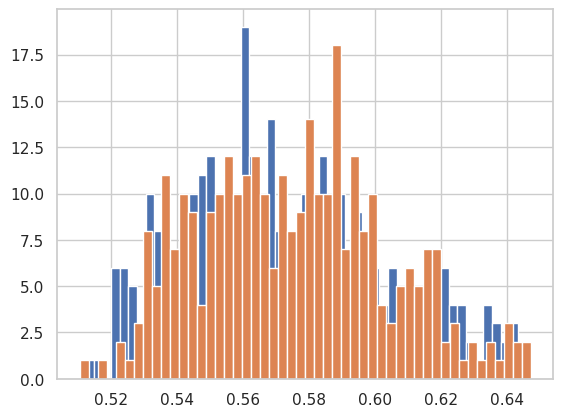

In [372]:
# p1 = df_metrics[ 'mean_test_score_p']
plt.hist(df_metrics[ 'mean_test_score_p'],bins=50)
plt.hist(df_metrics[ 'mean_test_score_e'],bins=50)

In [ ]:
# embedded_best_metrics['mean_test_score'].loc[1:10]
# embedded_best_metrics['mean_test_scomean_test_score_pe'].loc[10:20]
b_bns = np.arange(0.0, 1.0, 0.101)
b_bns

plt.hist(df_metrics['Y_bit_pct_p'], bins=b_bns)

<Figure size 1000x600 with 0 Axes>

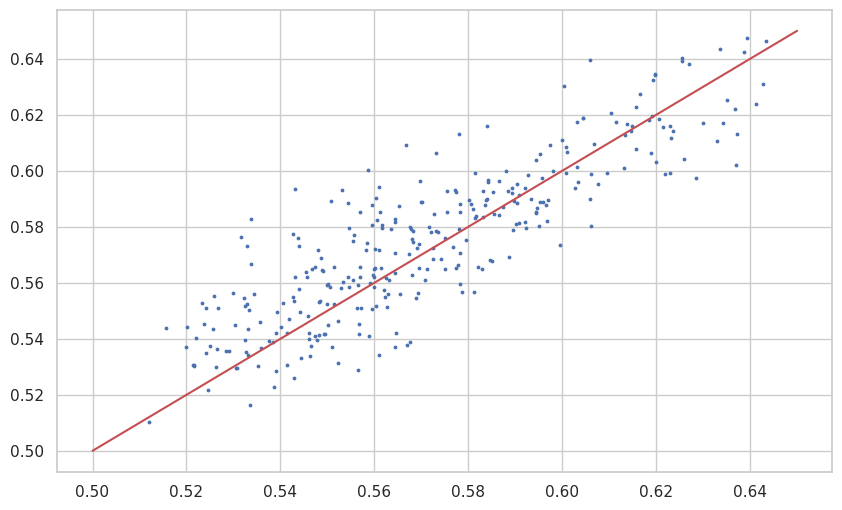

In [421]:
# plt.figure(figsize = (10,6))
# plt.scatter(df_metrics[ 'mean_test_score_p'],df_metrics[ 'mean_test_score_e'], s= 3.0)
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='mean_test_score_p', ylabel='mean_test_score_e'>

Text(0.5, 1.0, 'ROC AUC - Profiles vs. Embeddings, color coded on Set Percentage')

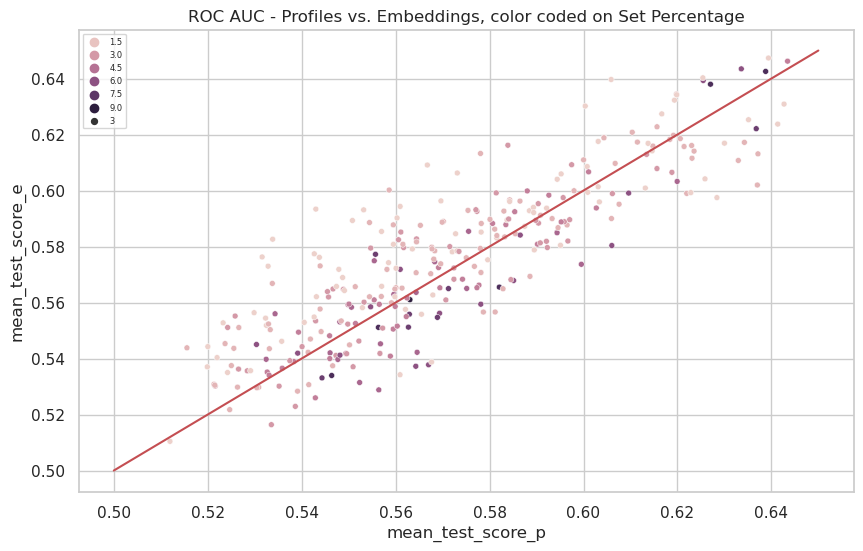

In [431]:
plt.figure(figsize = (10,6))
sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'Y_bit_pct_grp', legend ='brief',size = 3)
plt.title('ROC AUC - Profiles vs. Embeddings, color coded on Set Percentage')
plt.legend(fontsize='6', title_fontsize='14')
plt.plot([0.5,0.65],[0.5,0.65], color = 'r')
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='mean_test_score_p', ylabel='mean_test_score_e'>

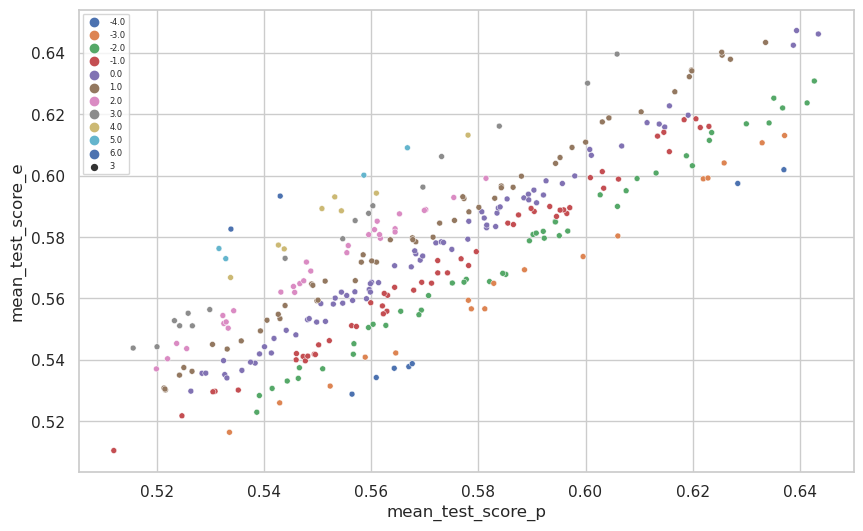

In [422]:
plt.figure(figsize = (10,6))
sns.scatterplot(data= df_metrics, x = 'mean_test_score_p' , y = 'mean_test_score_e', hue = 'mean_score_diff_grp', palette = 'deep', legend ='brief', size = 3)
plt.legend(fontsize='6', title_fontsize='14')
plt.title('ROC AUC - Profiles vs. Embeddings, grouped by ROC_AUC Difference')
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

In [370]:
df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

,Y_bit,Y_bit_pct_p,mean_test_score_p,precision_p,accuracy_p,recall_p,f1_p,index_e,Y_bit_pct_e,mean_test_score_e,precision_e,accuracy_e,recall_e,f1_e,Y_bit_description_e,_merge,mean_score_diff,mean_score_diff_pct
57,134,0.399405,0.643446,0.603066,0.645556,0.286061,0.388052,57,0.399405,0.646208,0.622458,0.629127,0.142222,0.231541,LumpedHydrophobe LumpedHydrophobe |0 4|4 0|,both,0.002762,0.429309
267,5941,0.126677,0.641345,0.446429,0.875952,0.016057,0.030998,267,0.126677,0.623737,0.470588,0.876270,0.010276,0.020113,Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...,both,-0.017608,-2.745424
314,10462,0.111504,0.642696,0.433333,0.885556,0.018131,0.034806,314,0.111504,0.630882,0.441860,0.885794,0.013250,0.025728,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,both,-0.011815,-1.838307


,Y_bit,Y_bit_pct_p,mean_test_score_p,precision_p,accuracy_p,recall_p,f1_p,index_e,Y_bit_pct_e,mean_test_score_e,precision_e,accuracy_e,recall_e,f1_e,Y_bit_description_e,_merge,mean_score_diff,mean_score_diff_pct
160,2053,0.110238,0.519908,0.0,0.890794,0.000000,0.000000,160,0.110238,0.537036,0.000000,0.890952,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|,both,0.017128,3.294412
175,2191,0.181721,0.515570,0.6,0.820238,0.003968,0.007884,175,0.181721,0.543838,0.333333,0.819841,0.000882,0.001759,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...,both,0.028267,5.482699
238,5252,0.137792,0.511957,0.0,0.866111,0.000000,0.000000,238,0.137792,0.510425,0.000000,0.866349,0.000000,0.000000,Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,both,-0.001532,-0.299256


In [304]:
print()
print(f" num of bits where Embedded score improvement < 0%      : {(df_metrics.mean_score_diff_pct< 0.00).sum()} ")
print(f" num of bits where Embedded score improvement 0% to 5%  : {df_metrics.mean_score_diff_pct.between(0.0, 5.0, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement 5% to 10% : {df_metrics.mean_score_diff_pct.between(5.0, 10.00, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement < 0%      : {(df_metrics.mean_score_diff_pct >= 10.00).sum()}  ")
print()
# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})


 num of bits where Embedded score improvement < 0%      : 124 
 num of bits where Embedded score improvement 0% to 5%  : 165
 num of bits where Embedded score improvement 5% to 10% : 26
 num of bits where Embedded score improvement < 0%      : 0  



### Comparative Bar charts 

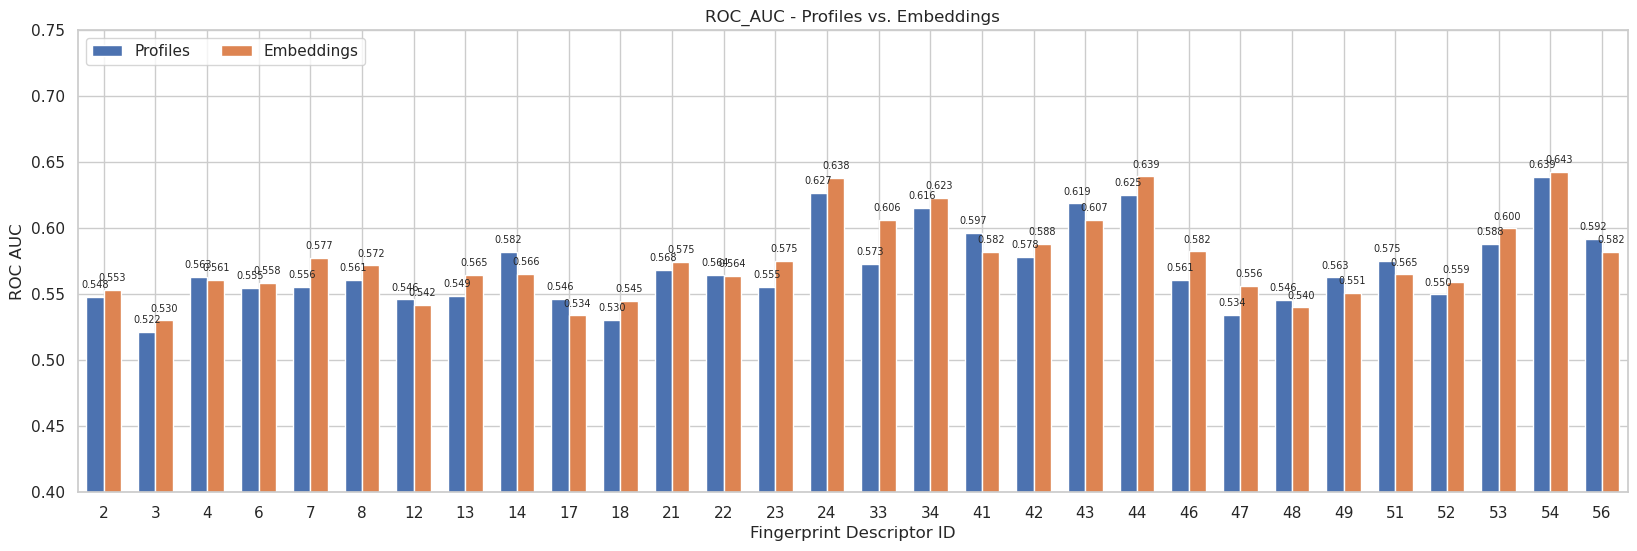

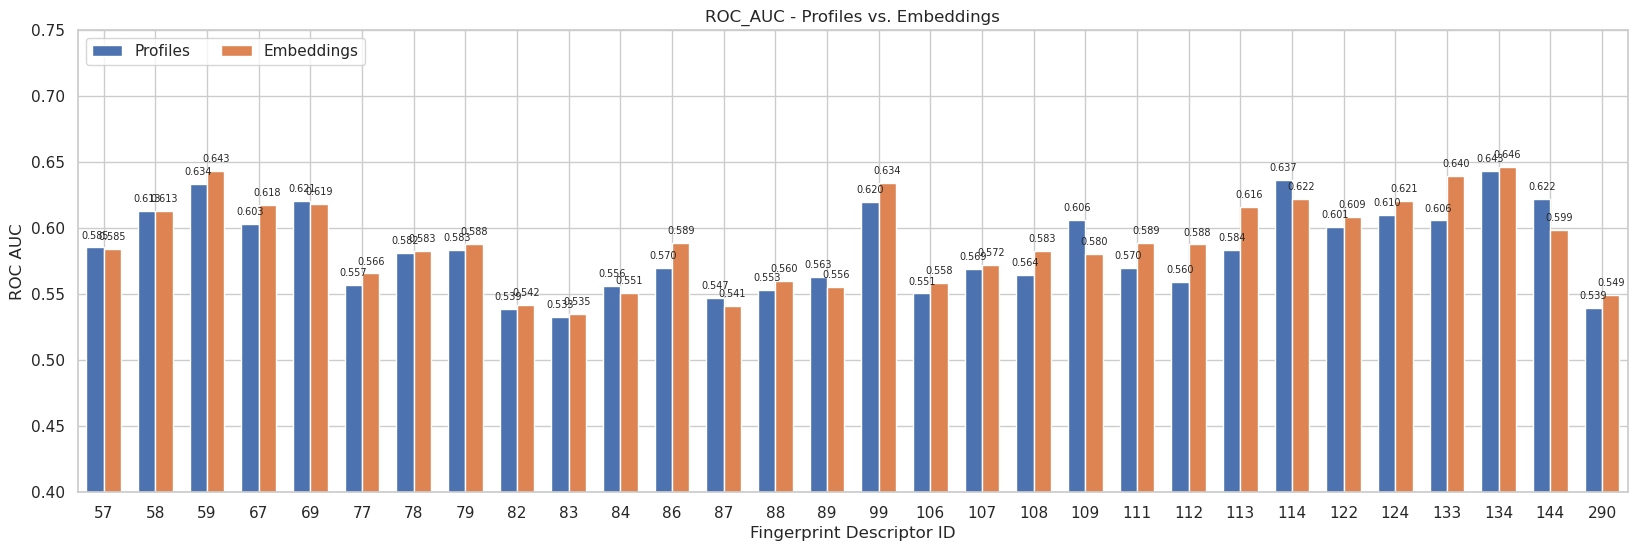

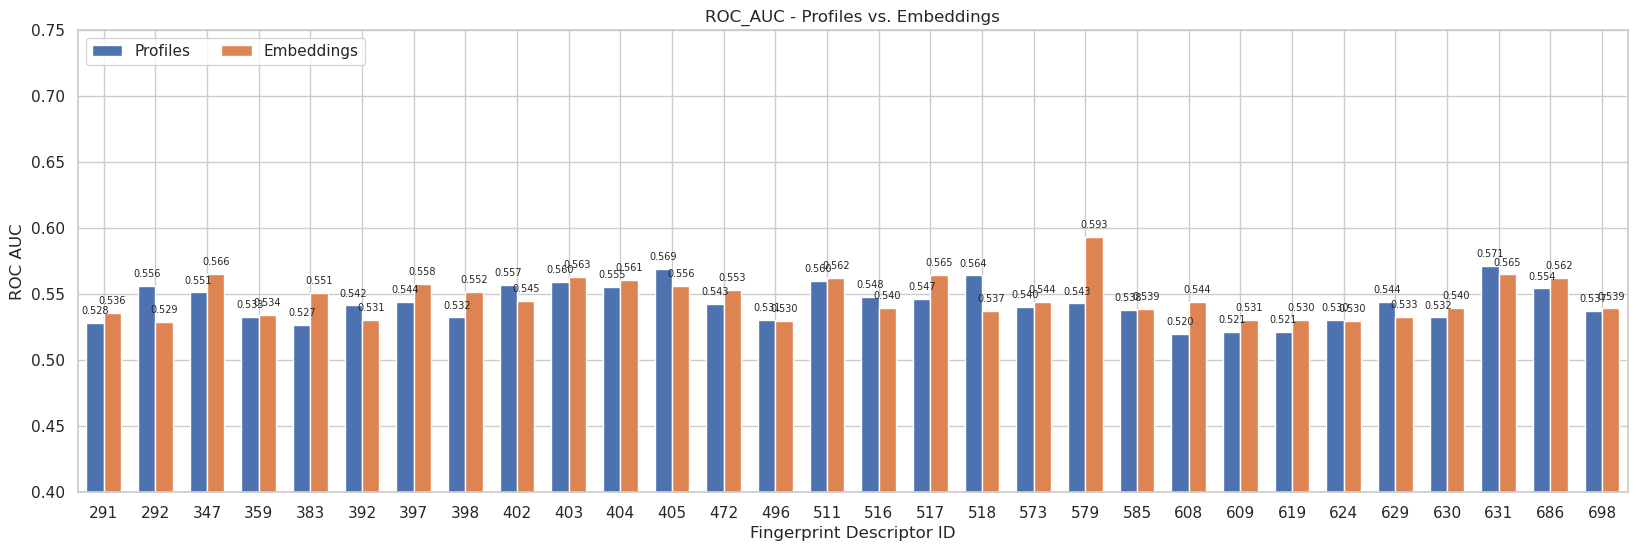

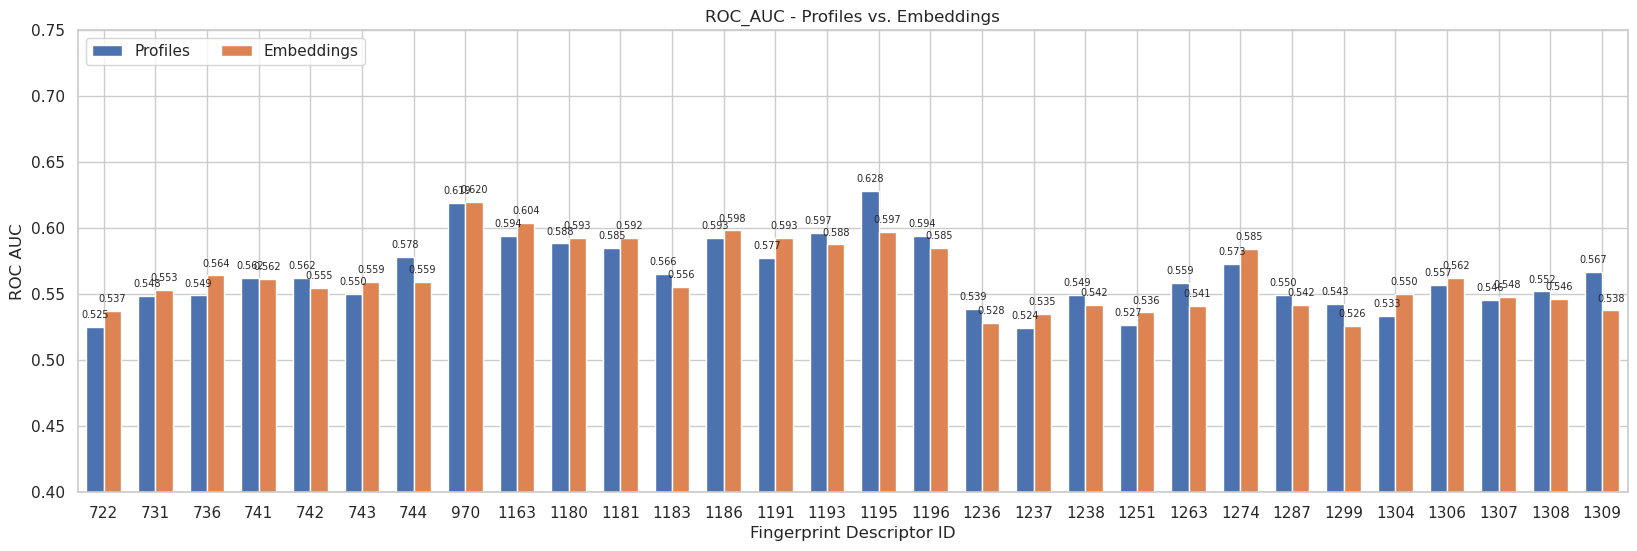

In [175]:
comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start=  0, end =30, column = 'mean_test_score')
comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 30, end =60, column = 'mean_test_score')
comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 60, end =90, column = 'mean_test_score')
comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 90, end =120, column = 'mean_test_score')
# comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 0, end  =10, column = 'mean_test_score')

# Misc

In [200]:
# data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# Fingerprint_bits = profile_best_metrics.Y_bit
# scores = {
#     'Profiles': profile_best_metrics.mean_test_score,
#     'Embeddings': embedded_best_metrics.mean_test_score,
# }

# x = np.arange(len(Fingerprint_bits))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
# fig, ax = plt.subplots(figsize=(20,6))

# # for attribute, measurement in test_scores.items():
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
# multiplier += 1
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# # Add some text for labels, title and custom x-axis tick labels, etc.
# _ = ax.set_ylabel('ROC AUC')
# _ = ax.set_xlabel('Fingerprint Descriptor ID')
# _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
# _ = ax.set_xticks(x + width/2, Fingerprint_bits)
# _ = ax.legend(loc='upper left', ncols=3)
# _ = ax.set_ylim(0.4, 0.75)
# _ = ax.set_xlim(-1, 37)
 
